## Content
* Data ingestion
    * Remove outliers
    * Remove adoption features not in ABM
    * Data splitting for CV
* Features preparation
    * Pipeline preparation
    * Features names collection
* Model selection
    * Functions for models results
    * Functions for models' error analyis
    * Models training
    * Results
* Final models tuning and training

In [1]:
import numpy as np
import pandas as pd
import math
import joblib
import os

In [2]:
import custom_transformers
from importlib import reload
reload(custom_transformers)

<module 'custom_transformers' from 'C:\\Users\\giaco\\sbp-adoption-abm-operational\\ml_models\\custom_transformers.py'>

In [3]:
from custom_transformers import (
    TransformAdoptionFeatures,
    TransformCensusFeatures, 
    TransformClimateFeatures,
    TransformSoilFeatures,
    TransformEconomicFeatures,
)

In [4]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
 # How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=10)

# Data ingestion

In [7]:
path_to_dataset = "Municipalities final dataset for analysis.csv"

In [8]:
dataset_original = pd.read_csv(path_to_dataset, index_col=['Municipality', 'Year'])

In [9]:
# Remove outliers adoption_in_year
outliers = dataset_original.loc[dataset_original['adoption_in_year'] > 0.12].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([('Alcochete', 2010),
            ('Alcochete', 2011),
            ('Alcochete', 2012)],
           names=['Municipality', 'Year'])


In [10]:
dataset_original.shape

(1238, 45)

In [11]:
dataset = dataset_original.reset_index(drop=True)

### Create a mapping of each new instance to municipality and year it's referring to

In [12]:
map_instances_to_munic_year = dict(zip(dataset.index, dataset_original.index))

## Final number of instances and features

In [13]:
dataset.shape

(1238, 45)

## Copy the data splitting label and features

In [14]:
dataset_labels = dataset['adoption_in_year'].copy()
dataset = dataset.drop('adoption_in_year', axis=1)

In [15]:
dataset_labels.describe()

count   1238.000000
mean       0.005416
std        0.007733
min        0.000000
25%        0.001189
50%        0.002468
75%        0.006698
max        0.086224
Name: adoption_in_year, dtype: float64

## Split for cross-validation

Split used in all the cross-validation, stratified based on the number of data points before the PCF project and during it

In [16]:
from sklearn.model_selection import StratifiedKFold, PredefinedSplit

First, generate the feature to split, the year of the instance

In [17]:
dataset_split = dataset_original.copy()

In [18]:
years = dataset_split.index.get_level_values(1).to_list()
dataset_split['Year'] = years

Second, get for each instance the test fold it has to belong to based on the split based on the created category

In [19]:
n_folds = 3
strat_split = StratifiedKFold(n_splits=n_folds, shuffle=True)

In [20]:
test_indexes = np.zeros(len(dataset_split))
fold = 0
for _, test_index in strat_split.split(dataset_split, dataset_split['Year']):
    for i in test_index:
        test_indexes[i] = fold
    fold += 1

Third, pass to the list of test folds indexes to generate the PredefinedSplit

In [21]:
cv_split = PredefinedSplit(test_indexes)

In [22]:
# Check ratio is kept
ratio_PCF_dataset = len(dataset_split.loc[(slice(None), [2007]), :]) / len(dataset_split)
test_set = dataset_split.iloc[np.where(test_indexes==1)]
ratio_PCF_test_set = len(test_set.loc[(slice(None), [2007]), :]) / len(test_set)
print(ratio_PCF_dataset, ratio_PCF_test_set)

0.05896607431340872 0.05811138014527845


# Features preparation

## Features names collection

### Pre-transformation

In [23]:
features_original = [feat for feat in dataset.columns]

In [24]:
features_adoption = [feat for feat in features_original if 'adoption' in feat]
features_climate = [feat for feat in features_original if '_t_' in feat or '_prec_' in feat]
features_soil = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features_economic = ['sbp_payment']

features_not_census = (features_adoption + features_climate + features_soil + features_economic)
features_census = [feat for feat in features_original if feat not in features_not_census]

In [25]:
len(features_census) + len(features_not_census)

44

### Post-transformation

In [26]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(), TransformCensusFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features = features + features_ind

In [27]:
len(features)

19

#### With squared cumulative adoption

In [28]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(add_square_cumul_adoption=True),
                TransformCensusFeatures(), TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features_sq = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features_sq = features_sq + features_ind

In [29]:
len(features_sq)

20

## Preparation pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [31]:
transformation_pipeline = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(), features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

dataset_transf = transformation_pipeline.fit_transform(dataset)

In [32]:
full_pipeline_stand = Pipeline([
    ('transformation', transformation_pipeline),
    ('scaling', StandardScaler())
])

In [33]:
dataset_prepared_stand = full_pipeline_stand.fit_transform(dataset)

In [34]:
dataset_prepared_stand.shape

(1238, 19)

In [35]:
# Print prepared data as a DataFrame
pd.DataFrame(dataset_prepared_stand, columns=features, index=dataset.index).head()

,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_mean,educ_second_super,farmers_over65,inc_mainly_ext,educ_none,work_unit_100ha,agric_area_owned,lu_per_agric_area,av_d_mean_t_average_munic,av_d_max_t_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,sbp_payment
0,-0.696230,-1.196227,-1.153109,-0.943122,-0.320601,0.507995,1.278940,0.210649,1.518544,1.697841,-0.382745,0.065617,-0.290110,-0.215745,-0.642702,2.669322,-0.637856,-1.278869,-0.550178
1,-0.420883,-1.153950,-1.187311,-0.944092,-0.317685,0.675081,1.296645,0.101147,1.508777,1.800497,-0.397201,0.065617,-0.290110,-0.215745,-0.642702,2.669322,-0.637856,-1.278869,-0.550178
2,-0.270694,-1.105143,-1.221514,-0.945117,-0.314770,0.851517,1.314419,-0.008356,1.499009,1.903545,-0.411657,0.065617,-0.290110,-0.215745,-0.642702,2.669322,-0.637856,-1.278869,-0.550178
3,-0.227782,-1.002478,-1.255717,-0.946200,-0.311854,1.038112,1.332261,-0.117859,1.489242,2.006989,-0.426112,0.065617,-0.290110,-0.215745,-0.642702,2.669322,-0.637856,-1.278869,-0.550178
4,-0.088321,-0.901823,-1.289920,-0.947348,-0.308938,1.235767,1.350171,-0.227361,1.479474,2.110830,-0.440568,0.065617,-0.290110,-0.215745,-0.642702,2.669322,-0.637856,-1.278869,-0.550178


### With squared cumulative adoption

In [36]:
transformation_pipeline_sq = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(add_square_cumul_adoption=True),
     features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

In [37]:
full_pipeline_stand_sq = Pipeline([
    ('transformation', transformation_pipeline_sq),
    ('scaling', StandardScaler())
])

In [38]:
dataset_stand_sq_cum_ad = full_pipeline_stand_sq.fit_transform(dataset)

In [39]:
dataset_stand_sq_cum_ad.shape

(1238, 20)

# Model selection

* Linear regression with Elastic Net regularization
    * With squared cumulative adoption
    * Polynomial
* SVM
    * Linear
    * With squared cumulative adoption
    * Non-linear

In [40]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone

In [41]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

In [42]:
from scipy.stats import expon, uniform, reciprocal

## Functions for models results

In [43]:
cols = ['cv RMSE_mean', 'cv RMSE std', 'cv adjR2 mean', 'cv adjR2 std', 'train set RMSE', 'train set adjR2']
models_results = pd.DataFrame(columns=cols, dtype=np.float64)

In [44]:
def display_scores(scores, score_name):
    print('Cross-validation', score_name)
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    print('')

In [45]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [46]:
from sklearn.model_selection import KFold

def cross_val_rmse_r2(reg, dataset_prepared, cv_split):
    scores = cross_validate(reg, dataset_prepared, dataset_labels,
                            scoring=['neg_mean_squared_error', 'r2'], cv=cv_split)
    rmse_scores = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2_scores = scores['test_r2']
    adj_r2_scores = adjusted_r2(r2_scores, (dataset_prepared.shape[0] // n_folds), dataset_prepared.shape[1])
    cv_scores = {'RMSE': rmse_scores, 'adjR2': adj_r2_scores}
    return cv_scores

In [47]:
def predict_train_set(reg, dataset_prepared):
    reg.fit(dataset_prepared, dataset_labels)
    predictions = reg.predict(dataset_prepared)
    mse = mean_squared_error(dataset_labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(dataset_labels, predictions)
    adj_r2 = adjusted_r2(r2, dataset_prepared.shape[0], dataset_prepared.shape[1])
    print('Scores on training set')
    print('RMSE score:', rmse)
    print('Adjusted R2 score:', adj_r2)
    return (rmse, adj_r2)

In [48]:
def load_model_results(reg, reg_name, results_df, cv_scores, train_results):
    df_cols = results_df.columns
    
    # Add cv columns
    for score_name, score_values in cv_scores.items():
        col_mean = [col for col in df_cols if ('cv' in col) and (score_name in col) and ('mean' in col)]
        col_std = [col for col in df_cols if ('cv' in col) and (score_name in col) and ('std' in col)]
        results_df.loc[reg_name, col_mean] = score_values.mean()
        results_df.loc[reg_name, col_std] = score_values.std()
    # Add training set results columns
    cols_train = [col for col in df_cols if ('train' in col)]
    results_df.loc[reg_name, cols_train] = train_results

In [49]:
def test_regressor(reg, dataset_prepared, labels, reg_name=None, results_df=models_results, cv_split=cv_split):  
    """
    Function to:
    - train a regressor using cross validation, reporting both RMSE and adjusted R2 score
    - train a regressor on the training set, to check it for overfiting
    - load the model performances in a dataframe to keep all models results
    
    reg_name: how to report the model's results in the DataFrame with the results. If None, do not add it.
    """
    cv_scores = cross_val_rmse_r2(reg, dataset_prepared, cv_split)
    print("Cross validation scores")
    for score_name, score_value in cv_scores.items():
        display_scores(score_value, score_name)
    print("")

    train_results = predict_train_set(reg, dataset_prepared)
        
    if reg_name != None:
        load_model_results(reg, reg_name, results_df, cv_scores, train_results)

In [50]:
def get_grid_search_results(gs):
    best_est = gs.best_estimator_
    print("Best estimator:", best_est)
    print("Best parameters:", gs.best_params_)
    for scorer_name in gs.scorer_.keys():
        res_test = gs.cv_results_['mean_test_' + scorer_name][gs.best_index_]
        res_train = gs.cv_results_['mean_train_' + scorer_name][gs.best_index_]
        print("")
        print(scorer_name + ' mean on test sets:', res_test)
        print(scorer_name + ' mean on train sets:', res_train)

## Functions for models' analysis

In [51]:
def plot_validation_curves(estimator, param_name, param_values, scoring, dataset, labels):
    train_errors, val_errors = [], []
    for param in param_values:
        estimator.set_params(**{param_name:param})
        scores = cross_validate(estimator, dataset, labels, scoring=scoring, 
                                cv=cv_split, n_jobs=-1, return_train_score=True)
        train_errors.append(-scores['train_score'].mean())
        val_errors.append(-scores['test_score'].mean())

    plt.plot(val_errors, "b-", linewidth=2, label="Validation set")
    plt.plot(train_errors, "r--", linewidth=2, label="Training set")
    plt.legend(loc="upper right", fontsize=12)
    x = np.arange(0, len(param_values), 1)
    plt.xticks(x, np.round(param_values, 2))
    plt.xlabel(param_name + " value", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.show()

In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, fig_name=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    steps = np.arange(100, len(X_train), 100)
    for m in steps:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(steps, np.sqrt(train_errors), "r-+", linewidth=2, label="Training error")
    plt.plot(steps, np.sqrt(val_errors), "b-", linewidth=3, label="Validation error")
    plt.legend(loc="lower right", fontsize=13)   
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Root mean squared error", fontsize=14)
    
    if fig_name != None:
        save_fig((fig_name))

### Errors analysis

In [53]:
def plot_pred_lab(preds, labels):
    # Bigger axis
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.hist(preds, bins=20, range=[0., 0.35])
    ax1.set(title='Predictions')
    ax1.set_ylim([0, 2000])
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.hist(labels, bins=20, range=[0., 0.35])
    ax2.set(title='Labels')
    ax2.set_ylim([0, 2000])
    
    #Zoom closer to 0
    restr_preds = preds[preds > 0.0000001]
    restr_labels = labels[labels > 0.0000001]
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.hist(restr_preds, bins=20, range=[0., 0.05])
    ax3.set(title='Predictions no 0, restricted x axis')
    ax3.set_ylim([0, 1000])
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.hist(restr_labels, bins=20, range=[0., 0.05])
    ax4.set(title='Labels no 0, restricted x axis')  
    ax4.set_ylim([0, 1000])

In [54]:
def compare_pred_lab_distribution(preds, labels):
    plot_pred_lab(preds, labels)

In [55]:
def compare_total_adoption(preds, labels):
    # Uses the dataset already split but before further manipulation (as standardization)
    pastures_area_munic = dataset['pastures_area_munic'].to_numpy()
    tot_area_pred = (pastures_area_munic * preds).sum()
    tot_area_actual = (pastures_area_munic * labels).sum()
    print("Total area adopted predicted:", str(tot_area_pred))
    print("Actual total area adopted:", str(tot_area_actual))
    print("")

In [56]:
def compare_percentile(preds, labels, percentile, how=None):
    """
    Function to compare the predictions on the data with label below a percentile or above it (strictly)
    """
    perc_value = np.percentile(labels, percentile)
    if perc_value < 0.0000001:
        raise ValueError("The percentile value is 0. Choose a higher percentile.")
    if how == 'below':
        id_lab_in_perc = np.where((labels > 0.0000001) & (labels <= perc_value))
    elif how == 'above':
        id_lab_in_perc = np.where(labels > perc_value)
    else:
        raise ValueError("Value of 'how' not correctly specified (can be 'below' or 'above')")
    lab_in_perc = labels[id_lab_in_perc]
    pred_in_perc = preds[id_lab_in_perc]

    mse = mean_squared_error(lab_in_perc, pred_in_perc)
    print("Labels' " + str(percentile) + 'th percentile = ' + str(perc_value))
    print('Average label on data', how, str(percentile) + 'th percentile:', str(np.mean(lab_in_perc)))
    print('Average prediction on data', how, str(percentile) + 'th percentile:', str(np.mean(pred_in_perc)))
    print('RMSE on instances on data', how, str(percentile) + 'th percentile:', str(np.sqrt(mse)))
    print("")

In [57]:
def compare_first_adoption(preds, labels, dataset_prep, dataset_labels):
    idx = np.where((dataset_labels > 0.0000001) & (dataset_prepared_stand[:, 0] < 0.0000001))
    lab = labels[idx]
    pred = preds[idx]
    
    mse = mean_squared_error(lab, pred)
    print('Prediction on years with adoption after a year with no adoption')
    print('Average label:', str(np.mean(lab)))
    print('Average prediction:', str(np.mean(pred)))
    print('RMSE:', str(np.sqrt(mse)))
    print("")

In [58]:
def check_predicted_negative(preds, labels):
    idx_0_pred = np.where(preds < -0.000000001)
    pred_0 = preds[idx_0_pred]
    if pred_0.size == 0:
        print("For no instance a negative value is predicted")
    else:
        print("For", str(len(pred_0)), "instances a negative value is the predicted")
        print("Average value for these predictions:", str(np.mean(pred_0)))
        lab_corr = labels[idx_0_pred]
        print("Average value for the labels on these instances:", str(np.mean(lab_corr)))
    print("")    

In [59]:
def check_predicted_0s(preds, labels):
    idx_0_pred = np.where((preds < 0.000000001) & (preds > -0.000000001))
    pred_0 = preds[idx_0_pred]
    if pred_0.size == 0:
        print("For no instance 0 is the predicted value")
    else:
        print("For", str(len(pred_0)), "instances 0 is the predicted value")
        lab_corr = labels[idx_0_pred]
        print("Average value for the labels on these instances:", str(np.mean(lab_corr)))
    print("")

In [60]:
from IPython.display import display
    
def worst_predictions(preds, labels, num):
    # Uses the dataset already split but before further manipulation (as standardization)
    diff = abs(preds - labels)
    id_max_err = (-diff).argsort()[:num]
    pred_max_err = preds[id_max_err]
    lab_max_err = labels[id_max_err]
    pred_lab_diff = pred_max_err - lab_max_err

    dataset_with_indexes = dataset.rename(index=map_instances_to_munic_year)
    data_max_err_rows = dataset_with_indexes.iloc[id_max_err, :]
    data_max_err_rows.insert(0, 'Prediction', pred_max_err)
    data_max_err_rows.insert(1, 'Label', lab_max_err)
    data_max_err_rows.insert(2, 'Prediction - label', pred_lab_diff)
    
    print("Worst", str(num), "predictions:")
    display(data_max_err_rows)

In [61]:
def analyse_errors(reg, dataset_prep, dataset_labels, percentile=50, worse_pred_num=10):
    """ 
    Differs from the one in the Notebook for the 1 stage ML only from having taken away the performance on the labels = 0
    """
    labels = dataset_labels.to_numpy()
    preds = cross_val_predict(reg, dataset_prep, dataset_labels, cv=KFold(n_splits=3, random_state=42, shuffle=True))

    compare_pred_lab_distribution(preds, labels)
    compare_total_adoption(preds, labels)
    
    check_predicted_negative(preds, labels)
    check_predicted_0s(preds, labels)
    compare_percentile(preds, labels, percentile, how='below')
    compare_percentile(preds, labels, percentile, how='above')
    compare_first_adoption(preds, labels, dataset_prep, dataset_labels)

    worst_predictions(preds, labels, worse_pred_num)

## Linear regression (elastic net)

In [62]:
from sklearn.linear_model import SGDRegressor

In [63]:
el_net_lin_reg = SGDRegressor(penalty='elasticnet', learning_rate='adaptive')

param_grid = {
    #"tol": [5e-3],
    #"max_iter": [10000],
    "alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    }

srch_lin_reg = GridSearchCV(el_net_lin_reg, param_grid, cv=cv_split,
                            scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                            return_train_score=True, verbose=1)

srch_lin_reg.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    1.3s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
             estimator=SGDRegressor(learning_rate='adaptive',
                                    penalty='elasticnet'),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75])},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [64]:
get_grid_search_results(srch_lin_reg)

Best estimator: SGDRegressor(alpha=0.1, l1_ratio=0.0, learning_rate='adaptive',
             penalty='elasticnet')
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.0}

neg_root_mean_squared_error mean on test sets: -0.006961433460046376
neg_root_mean_squared_error mean on train sets: -0.006791123843371938

r2 mean on test sets: 0.18408061187787408
r2 mean on train sets: 0.22680912029873704


In [65]:
lin_reg = srch_lin_reg.best_estimator_
test_regressor(lin_reg, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0068281308 0.007217244  0.0068464851]
Mean: 0.006963953307810036
Standard deviation: 0.00017926025747785784

Cross-validation adjR2
Scores: [0.0971747588 0.1846152313 0.1499256864]
Mean: 0.1439052254763449
Standard deviation: 0.035950368744154845


Scores on training set
RMSE score: 0.006824177558907431
Adjusted R2 score: 0.2084394246413679


### Second iteration

In [66]:
param_grid = {
    'max_iter': [3000],
    "alpha": expon(scale=0.05),
    "l1_ratio": uniform(0.0, 1.0),
    }

srch_lin_reg_2 = RandomizedSearchCV(el_net_lin_reg, param_grid, cv=cv_split, n_iter=1000,
                                    scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                    return_train_score=True, verbose=1)

srch_lin_reg_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   40.3s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=SGDRegressor(learning_rate='adaptive',
                                          penalty='elasticnet'),
                   n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232738811C8>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232738816C8>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [67]:
get_grid_search_results(srch_lin_reg_2)

Best estimator: SGDRegressor(alpha=0.003138605151528447, l1_ratio=0.016941262870387663,
             learning_rate='adaptive', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.003138605151528447, 'l1_ratio': 0.016941262870387663, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.006971117705904404
neg_root_mean_squared_error mean on train sets: -0.0067851758088169

r2 mean on test sets: 0.1813228649374924
r2 mean on train sets: 0.22815039481829127


In [68]:
lin_reg = srch_lin_reg_2.best_estimator_
test_regressor(lin_reg, dataset_prepared_stand, dataset_labels, 'Linear Regression')

Cross validation scores
Cross-validation RMSE
Scores: [0.0068755792 0.0071831819 0.0068859068]
Mean: 0.006981555981080086
Standard deviation: 0.00014263340532169358

Cross-validation adjR2
Scores: [0.0845837733 0.1922935561 0.1401081328]
Mean: 0.1389951540669592
Standard deviation: 0.04397937677294308


Scores on training set
RMSE score: 0.006818492498411265
Adjusted R2 score: 0.20975773597420277


## Linear Regression with squared cumulative adoption

In [69]:
from sklearn.linear_model import SGDRegressor
el_net_lin_reg = SGDRegressor(penalty='elasticnet', learning_rate='adaptive')

In [70]:
param_grid = {
    'max_iter': [3000],
    "alpha": uniform(0.001, 0.05),
    "l1_ratio": uniform(0.0, 1.0),
    }

srch_lin_reg_sq = RandomizedSearchCV(el_net_lin_reg, param_grid, cv=cv_split, n_iter=1000,
                                    scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                    return_train_score=True, verbose=1)

srch_lin_reg_sq.fit(dataset_stand_sq_cum_ad, dataset_labels)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   33.0s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=SGDRegressor(learning_rate='adaptive',
                                          penalty='elasticnet'),
                   n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023274251688>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002327424D5C8>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [71]:
get_grid_search_results(srch_lin_reg_sq)

Best estimator: SGDRegressor(alpha=0.002088577098971466, l1_ratio=0.0017565592256356677,
             learning_rate='adaptive', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.002088577098971466, 'l1_ratio': 0.0017565592256356677, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.006710085302421481
neg_root_mean_squared_error mean on train sets: -0.00651235280683278

r2 mean on test sets: 0.24227553761454912
r2 mean on train sets: 0.2891410941762882


In [72]:
lin_reg_sq = srch_lin_reg_sq.best_estimator_
name = "Linear regression + cum_ad_sq"
test_regressor(lin_reg_sq, dataset_stand_sq_cum_ad, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0064803859 0.0069567914 0.0066570874]
Mean: 0.006698088269331802
Standard deviation: 0.00019664068955736728

Cross-validation adjR2
Scores: [0.1847119442 0.2404662287 0.1942517065]
Mean: 0.20647662645442585
Standard deviation: 0.024347779657841642


Scores on training set
RMSE score: 0.006539540772329467
Adjusted R2 score: 0.2724970935197494


## Polynomial regression

In [73]:
from sklearn.preprocessing import PolynomialFeatures

In [74]:
poly_features = PolynomialFeatures(degree=2, include_bias=False) # Already added by Elastic Net

In [75]:
full_pipeline_stand_poly = Pipeline([
    ('transformation', transformation_pipeline),
    ('poly_features', poly_features),
    ('scaling', StandardScaler())
])

In [76]:
dataset_prepared_stand_poly = full_pipeline_stand_poly.fit_transform(dataset)

In [77]:
dataset_prepared_stand_poly.shape

(1238, 209)


### Hyperparameters search on polynomial regression with elastic net regularization

In [78]:
from sklearn.linear_model import SGDRegressor

el_net_pol_reg = SGDRegressor(penalty='elasticnet', learning_rate='optimal') # Optimal much faster and converging

param_grid = {
    "max_iter": [3000],
    "alpha": [0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    }

srch_pol_reg = GridSearchCV(el_net_pol_reg, param_grid, cv=cv_split,
                                   scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                   return_train_score=True, verbose=1)

srch_pol_reg.fit(dataset_prepared_stand_poly, dataset_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximu

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
             estimator=SGDRegressor(learning_rate='optimal',
                                    penalty='elasticnet'),
             param_grid={'alpha': [0.01, 0.1, 1],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': [3000]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [79]:
get_grid_search_results(srch_pol_reg)

Best estimator: SGDRegressor(alpha=0.1, l1_ratio=0.25, learning_rate='optimal', max_iter=3000,
             penalty='elasticnet')
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.25, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.007724907700068509
neg_root_mean_squared_error mean on train sets: -0.007727231004019708

r2 mean on test sets: -0.0023958935400603862
r2 mean on train sets: -0.0003001282693805655


In [80]:
pol_reg = srch_pol_reg.best_estimator_
test_regressor(pol_reg, dataset_prepared_stand_poly, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [7.3583196186e-03 3.8160182642e+07 7.6306424876e-03]
Mean: 12720060.885803578
Standard deviation: 17988882.60831615

Cross-validation adjR2
Scores: [-1.0346608118e+00 -4.4235954471e+19 -1.0491722743e+00]
Mean: -1.4745318157030414e+19
Standard deviation: 2.0853028919178658e+19


Scores on training set
RMSE score: 0.007731137055736371
Adjusted R2 score: -0.20371712020818444


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### Second iteration

In [81]:
param_grid = {
    'max_iter': [3000],
    "alpha": expon(scale=0.01),
    "l1_ratio": uniform(0, 0.5),
    }

srch_pol_reg_2 = RandomizedSearchCV(el_net_pol_reg, param_grid, cv=cv_split, n_iter=100,
                                        scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                        return_train_score=True, verbose=1)

srch_pol_reg_2.fit(dataset_prepared_stand_poly, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.6min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=SGDRegressor(learning_rate='optimal',
                                          penalty='elasticnet'),
                   n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232742EF908>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232742F4FC8>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [82]:
get_grid_search_results(srch_pol_reg_2)

Best estimator: SGDRegressor(alpha=0.0629985133150877, l1_ratio=0.4751546713633335,
             learning_rate='optimal', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.0629985133150877, 'l1_ratio': 0.4751546713633335, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.007718589172359691
neg_root_mean_squared_error mean on train sets: -0.007733580381857942

r2 mean on test sets: -0.0008269147282153148
r2 mean on train sets: -0.0019552537607551526


In [83]:
pol_reg = srch_pol_reg_2.best_estimator_
name = 'Polynomial Regression'
test_regressor(pol_reg, dataset_prepared_stand_poly, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0073583759 0.008203056  0.0076692942]
Mean: 0.007743575340281778
Standard deviation: 0.0003488164568576335

Cross-validation adjR2
Scores: [-1.0346919125 -1.0441175211 -1.0699843201]
Mean: -1.0495979178845616
Standard deviation: 0.014920111036491374


Scores on training set
RMSE score: 0.007729836716993171
Adjusted R2 score: -0.20331223581325264


## Linear SVM

In [84]:
from sklearn.svm import LinearSVR

In [85]:
lin_svr = LinearSVR(max_iter=3000)

param_grid = {
    "epsilon": [0, 0.001, 0.01, 1],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"]
    }

srch_lin_svr = GridSearchCV(lin_svr, param_grid, cv=cv_split,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarni

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
             estimator=LinearSVR(max_iter=3000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0, 0.001, 0.01, 1],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [86]:
get_grid_search_results(srch_lin_svr)

Best estimator: LinearSVR(C=0.01, epsilon=0, loss='squared_epsilon_insensitive', max_iter=3000)
Best parameters: {'C': 0.01, 'epsilon': 0, 'loss': 'squared_epsilon_insensitive'}

neg_root_mean_squared_error mean on test sets: -0.006969010208365412
neg_root_mean_squared_error mean on train sets: -0.006787353472561469

r2 mean on test sets: 0.18242066602700427
r2 mean on train sets: 0.22769417561307695


In [87]:
lin_svr = srch_lin_svr.best_estimator_
test_regressor(lin_reg_sq, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0068431782 0.0072470283 0.0068830986]
Mean: 0.006991101701809999
Standard deviation: 0.00018169981010727912

Cross-validation adjR2
Scores: [0.0931912063 0.1778714483 0.1408093452]
Mean: 0.13729066659517783
Standard deviation: 0.03465998334238015


Scores on training set
RMSE score: 0.006807525614128264
Adjusted R2 score: 0.21229774781938981


### Second iteration

In [88]:
param_grid = {
    "epsilon": expon(scale=0),
    "C": expon(scale=0.1),
    "loss": ["squared_epsilon_insensitive"]
    }

srch_lin_svr_2 = RandomizedSearchCV(lin_svr, param_grid, cv=cv_split, n_iter=50,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.5s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=LinearSVR(C=0.01, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=3000),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FBD8C8>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FC6A48>,
                                        'loss': ['squared_epsilon_insensitive']},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [89]:
lin_svr = srch_lin_svr.best_estimator_
test_regressor(lin_reg_sq, dataset_prepared_stand, dataset_labels, 'Linear SVM')

Cross validation scores
Cross-validation RMSE
Scores: [0.0068404131 0.0072545182 0.0068843839]
Mean: 0.006993105072331303
Standard deviation: 0.0001857166192840848

Cross-validation adjR2
Scores: [0.0939238752 0.1761711993 0.1404884496]
Mean: 0.13686117468601663
Standard deviation: 0.03367514833919346


Scores on training set
RMSE score: 0.0068077177796571665
Adjusted R2 score: 0.21225327604948596


## Linear SVM with squared cumulative adoption

In [90]:
param_grid = {
    "epsilon": expon(scale=0),
    "C": expon(scale=0.1),
    "loss": ["squared_epsilon_insensitive"]
    }

srch_lin_svr_sq_2 = RandomizedSearchCV(lin_svr, param_grid, cv=cv_split, n_iter=50,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr_sq_2.fit(dataset_stand_sq_cum_ad, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.8s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=LinearSVR(C=0.01, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=3000),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FB1288>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FC1648>,
                                        'loss': ['squared_epsilon_insensitive']},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [91]:
get_grid_search_results(srch_lin_svr_sq_2)

Best estimator: LinearSVR(C=0.5534785384380068, loss='squared_epsilon_insensitive',
          max_iter=3000)
Best parameters: {'C': 0.5534785384380068, 'epsilon': 0.0, 'loss': 'squared_epsilon_insensitive'}

neg_root_mean_squared_error mean on test sets: -0.006693175807011859
neg_root_mean_squared_error mean on train sets: -0.006505222706168364

r2 mean on test sets: 0.24620326867489803
r2 mean on train sets: 0.2906710911884742


In [92]:
lin_svr_sq = srch_lin_svr_sq_2.best_estimator_
name = "Linear SVM + cum_ad_sq"
test_regressor(lin_svr_sq, dataset_stand_sq_cum_ad, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0064714281 0.0069506374 0.0066586532]
Mean: 0.006693572906571649
Standard deviation: 0.00019718847490015384

Cross-validation adjR2
Scores: [0.1869643377 0.2418093988 0.19387264  ]
Mean: 0.20754879216989333
Standard deviation: 0.024389520091372883


Scores on training set
RMSE score: 0.0065370662257006485
Adjusted R2 score: 0.27304756008127495


## Non-linear SVM

In [93]:
from sklearn.svm import SVR

### GridSearchCV

In [94]:
from sklearn.model_selection import KFold

In [95]:
nl_svr = SVR()

param_grid = {
    "degree": [2, 3],
    "epsilon": [0.0001, 0.001, 0.1],
    "C": [0.001, 0.01, 0.1, 1],
    "gamma": [0.001, 0.01, 0.1, 1],
    }
 
srch_nl_svr = GridSearchCV(nl_svr, param_grid, cv=cv_split,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_nl_svr.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   14.9s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'degree': [2, 3],
                         'epsilon': [0.0001, 0.001, 0.1],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [96]:
get_grid_search_results(srch_nl_svr)

Best estimator: SVR(C=0.01, degree=2, epsilon=0.001, gamma=0.1)
Best parameters: {'C': 0.01, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.1}

neg_root_mean_squared_error mean on test sets: -0.006189450443366463
neg_root_mean_squared_error mean on train sets: -0.0054603361233182554

r2 mean on test sets: 0.3555829778148179
r2 mean on train sets: 0.500638687990551


In [97]:
best_nl_svr = srch_nl_svr.best_estimator_
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0059452512 0.0064414843 0.0061816159]
Mean: 0.006189450443366463
Standard deviation: 0.00020266205650297945

Cross-validation adjR2
Scores: [0.3155520266 0.3504812079 0.3070122034]
Mean: 0.32434847929053606
Standard deviation: 0.018804640774544155


Scores on training set
RMSE score: 0.005532546142797762
Adjusted R2 score: 0.47972422061953546


### Second iteration

In [98]:
nl_svr = SVR()

param_grid = {
    "degree": [2],
    "epsilon": expon(scale = 0.001),
    "C": expon(scale = 0.1),
    "gamma": expon(scale=0.01)
    }

srch_nl_svr_2 = RandomizedSearchCV(nl_svr, param_grid, cv=cv_split, n_iter=300,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_nl_svr_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   56.1s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=SVR(), n_iter=300,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FD5308>,
                                        'degree': [2],
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FD5DC8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023273FD5048>},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [99]:
get_grid_search_results(srch_nl_svr_2)

Best estimator: SVR(C=0.04426005290076512, degree=2, epsilon=0.0023379804957184,
    gamma=0.03241953111615956)
Best parameters: {'C': 0.04426005290076512, 'degree': 2, 'epsilon': 0.0023379804957184, 'gamma': 0.03241953111615956}

neg_root_mean_squared_error mean on test sets: -0.006231825404602888
neg_root_mean_squared_error mean on train sets: -0.005439492383074816

r2 mean on test sets: 0.3472230349801559
r2 mean on train sets: 0.504312124722867


In [100]:
best_nl_svr = srch_nl_svr_2.best_estimator_
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0060124727 0.0065793985 0.006103605 ]
Mean: 0.006231825404602888
Standard deviation: 0.00024857135076988

Cross-validation adjR2
Scores: [0.299986748  0.322370662  0.3243925955]
Mean: 0.31558333514501036
Standard deviation: 0.011059300807066977


Scores on training set
RMSE score: 0.005506046142999872
Adjusted R2 score: 0.4846963575732497


### Third iteration

In [101]:
get_grid_search_results(srch_nl_svr)
print("")
get_grid_search_results(srch_nl_svr_2)

Best estimator: SVR(C=0.01, degree=2, epsilon=0.001, gamma=0.1)
Best parameters: {'C': 0.01, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.1}

neg_root_mean_squared_error mean on test sets: -0.006189450443366463
neg_root_mean_squared_error mean on train sets: -0.0054603361233182554

r2 mean on test sets: 0.3555829778148179
r2 mean on train sets: 0.500638687990551

Best estimator: SVR(C=0.04426005290076512, degree=2, epsilon=0.0023379804957184,
    gamma=0.03241953111615956)
Best parameters: {'C': 0.04426005290076512, 'degree': 2, 'epsilon': 0.0023379804957184, 'gamma': 0.03241953111615956}

neg_root_mean_squared_error mean on test sets: -0.006231825404602888
neg_root_mean_squared_error mean on train sets: -0.005439492383074816

r2 mean on test sets: 0.3472230349801559
r2 mean on train sets: 0.504312124722867


In [102]:
from sklearn.svm import SVR
nl_svr = SVR()

param_grid = {
    "degree": [2],
    "epsilon": expon(scale = 0.0017),
    "C": expon(scale = 0.26),
    "gamma": expon(scale=0.004)
    }
 
srch_nl_svr_3 = RandomizedSearchCV(nl_svr, param_grid, cv=cv_split, n_iter=500,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)
srch_nl_svr_3.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  1.9min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 1])),
                   estimator=SVR(), n_iter=500,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023274064788>,
                                        'degree': [2],
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023274064AC8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023274064088>},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [103]:
get_grid_search_results(srch_nl_svr_3)

Best estimator: SVR(C=0.11514122657802402, degree=2, epsilon=0.002419863071211297,
    gamma=0.011484700267443705)
Best parameters: {'C': 0.11514122657802402, 'degree': 2, 'epsilon': 0.002419863071211297, 'gamma': 0.011484700267443705}

neg_root_mean_squared_error mean on test sets: -0.006259856269701307
neg_root_mean_squared_error mean on train sets: -0.005754742544672463

r2 mean on test sets: 0.34117485144908005
r2 mean on train sets: 0.44518936865033537


In [104]:
best_nl_svr = srch_nl_svr_3.best_estimator_
name = "Non-linear SVM"
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0058651655 0.0065508539 0.0063635495]
Mean: 0.006259856269701307
Standard deviation: 0.0002893744477700403

Cross-validation adjR2
Scores: [0.3338675886 0.3282376791 0.2656207319]
Mean: 0.3092419998611528
Standard deviation: 0.030930408306649483


Scores on training set
RMSE score: 0.005803305984066052
Adjusted R2 score: 0.4275540878661227


# Models summary

In [105]:
dataset_labels.describe()

count   1238.000000
mean       0.005416
std        0.007733
min        0.000000
25%        0.001189
50%        0.002468
75%        0.006698
max        0.086224
Name: adoption_in_year, dtype: float64

In [106]:
models_results

,cv RMSE_mean,cv RMSE std,cv adjR2 mean,cv adjR2 std,train set RMSE,train set adjR2
Linear Regression,0.006982,0.000143,0.138995,0.043979,0.006818,0.209758
Linear regression + cum_ad_sq,0.006698,0.000197,0.206477,0.024348,0.006540,0.272497
Polynomial Regression,0.007744,0.000349,-1.049598,0.014920,0.007730,-0.203312
Linear SVM,0.006993,0.000186,0.136861,0.033675,0.006808,0.212253
Linear SVM + cum_ad_sq,0.006694,0.000197,0.207549,0.024390,0.006537,0.273048
Non-linear SVM,0.006260,0.000289,0.309242,0.030930,0.005803,0.427554


In [107]:
models_results[['cv RMSE_mean', 'cv adjR2 mean', 'train set RMSE', 'train set adjR2']]

,cv RMSE_mean,cv adjR2 mean,train set RMSE,train set adjR2
Linear Regression,0.006982,0.138995,0.006818,0.209758
Linear regression + cum_ad_sq,0.006698,0.206477,0.006540,0.272497
Polynomial Regression,0.007744,-1.049598,0.007730,-0.203312
Linear SVM,0.006993,0.136861,0.006808,0.212253
Linear SVM + cum_ad_sq,0.006694,0.207549,0.006537,0.273048
Non-linear SVM,0.006260,0.309242,0.005803,0.427554


# Final models tuning and training
Using the Optuna library for Bayesian Optimization

In [108]:
from sklearn.model_selection import cross_val_score 
import optuna 
from optuna.samplers import TPESampler

In [109]:
from sklearn.svm import SVR

In [110]:
X = dataset_prepared_stand

def objective(trial):
    # Define the search space
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
    C = trial.suggest_loguniform('C', 0.01, 10)
    gamma = trial.suggest_loguniform('gamma', 0.001, 1)
    epsilon = trial.suggest_loguniform('epsilon', 0.001, 1)

    reg = SVR(degree=2,
              kernel=kernel,
              C=C,
              gamma=gamma,
              epsilon=epsilon)
    score = cross_val_score(reg, X, dataset_labels, scoring='neg_root_mean_squared_error',
                            cv=cv_split).mean()

    return score

In [111]:
study_nl_svm_all = optuna.create_study(study_name="nl_svr_optimization_all",
                                        direction="maximize",
                                        sampler=TPESampler())

[I 2022-07-24 18:06:35,523] A new study created in memory with name: nl_svr_optimization_all


In [112]:
%%time
# pass the objective function to method optimize()

study_nl_svm_all.optimize(objective, n_trials=2000)

[I 2022-07-24 18:06:35,587] Trial 0 finished with value: -0.030130768433350653 and parameters: {'kernel': 'rbf', 'C': 0.1847538974706291, 'gamma': 0.018031151202833457, 'epsilon': 0.03757961554848734}. Best is trial 0 with value: -0.030130768433350653.
[I 2022-07-24 18:06:35,603] Trial 1 finished with value: -0.03564469137116574 and parameters: {'kernel': 'rbf', 'C': 2.383091282420848, 'gamma': 0.025795940392481488, 'epsilon': 0.049207196122075414}. Best is trial 0 with value: -0.030130768433350653.
[I 2022-07-24 18:06:35,733] Trial 2 finished with value: -0.0064902364731021026 and parameters: {'kernel': 'rbf', 'C': 0.04413401298518994, 'gamma': 0.11930624982013716, 'epsilon': 0.0030793217782857083}. Best is trial 2 with value: -0.0064902364731021026.
[I 2022-07-24 18:06:35,748] Trial 3 finished with value: -0.03564469137116573 and parameters: {'kernel': 'poly', 'C': 0.06639028516718058, 'gamma': 0.001516530333556347, 'epsilon': 0.7814632362124664}. Best is trial 2 with value: -0.00649

[I 2022-07-24 18:06:40,929] Trial 31 finished with value: -0.0062902391547929965 and parameters: {'kernel': 'rbf', 'C': 0.18715716743119826, 'gamma': 0.008768962111110038, 'epsilon': 0.001866474346453064}. Best is trial 22 with value: -0.006191706968881502.
[I 2022-07-24 18:06:41,246] Trial 32 finished with value: -0.006483588539062764 and parameters: {'kernel': 'rbf', 'C': 0.2542468567561499, 'gamma': 0.028707076459201435, 'epsilon': 0.0015148026128100583}. Best is trial 22 with value: -0.006191706968881502.
[I 2022-07-24 18:06:41,460] Trial 33 finished with value: -0.006464724727713607 and parameters: {'kernel': 'rbf', 'C': 0.14663193885932765, 'gamma': 0.003930704268421286, 'epsilon': 0.0017097325519465527}. Best is trial 22 with value: -0.006191706968881502.
[I 2022-07-24 18:06:41,648] Trial 34 finished with value: -0.006549355833439997 and parameters: {'kernel': 'rbf', 'C': 0.04086048120148991, 'gamma': 0.008303115466230223, 'epsilon': 0.004171846507434394}. Best is trial 22 with 

[I 2022-07-24 18:06:50,871] Trial 62 finished with value: -0.006289400514385139 and parameters: {'kernel': 'rbf', 'C': 0.034005293815936526, 'gamma': 0.07288671397371749, 'epsilon': 0.001047747393434995}. Best is trial 53 with value: -0.006189690377769602.
[I 2022-07-24 18:06:51,015] Trial 63 finished with value: -0.006203249484539865 and parameters: {'kernel': 'rbf', 'C': 0.018604215802381627, 'gamma': 0.0406839246252728, 'epsilon': 0.001963724585466273}. Best is trial 53 with value: -0.006189690377769602.
[I 2022-07-24 18:06:51,161] Trial 64 finished with value: -0.006197666765523274 and parameters: {'kernel': 'rbf', 'C': 0.0188874585782988, 'gamma': 0.04286671095453275, 'epsilon': 0.002004216669338852}. Best is trial 53 with value: -0.006189690377769602.
[I 2022-07-24 18:06:51,341] Trial 65 finished with value: -0.006235588864435336 and parameters: {'kernel': 'rbf', 'C': 0.011755272693613924, 'gamma': 0.13968717529673103, 'epsilon': 0.0010011881323230172}. Best is trial 53 with valu

[I 2022-07-24 18:06:58,768] Trial 93 finished with value: -0.006202927948242479 and parameters: {'kernel': 'rbf', 'C': 0.02064414764896785, 'gamma': 0.05175895550816438, 'epsilon': 0.001168916785595187}. Best is trial 71 with value: -0.00616431250259565.
[I 2022-07-24 18:06:58,940] Trial 94 finished with value: -0.006390753540330225 and parameters: {'kernel': 'rbf', 'C': 0.027085578532688764, 'gamma': 0.18840618241717808, 'epsilon': 0.00153671640866565}. Best is trial 71 with value: -0.00616431250259565.
[I 2022-07-24 18:06:59,055] Trial 95 finished with value: -0.006201696701238316 and parameters: {'kernel': 'rbf', 'C': 0.0116320065810673, 'gamma': 0.062459111793206366, 'epsilon': 0.0029764172431372897}. Best is trial 71 with value: -0.00616431250259565.
[I 2022-07-24 18:06:59,252] Trial 96 finished with value: -0.006245703319982071 and parameters: {'kernel': 'rbf', 'C': 0.034944641142646504, 'gamma': 0.07172812300688884, 'epsilon': 0.0017954541371939389}. Best is trial 71 with value:

[I 2022-07-24 18:07:03,981] Trial 124 finished with value: -0.0061927751023920195 and parameters: {'kernel': 'rbf', 'C': 0.010142242793896531, 'gamma': 0.10308348970173481, 'epsilon': 0.0014489931832645923}. Best is trial 71 with value: -0.00616431250259565.
[I 2022-07-24 18:07:04,144] Trial 125 finished with value: -0.006161801624099547 and parameters: {'kernel': 'rbf', 'C': 0.013688017005461506, 'gamma': 0.0933774877804338, 'epsilon': 0.0017577646861417627}. Best is trial 125 with value: -0.006161801624099547.
[I 2022-07-24 18:07:04,282] Trial 126 finished with value: -0.006240022442208421 and parameters: {'kernel': 'rbf', 'C': 0.01356121540300276, 'gamma': 0.13690755706606014, 'epsilon': 0.002177632593823189}. Best is trial 125 with value: -0.006161801624099547.
[I 2022-07-24 18:07:04,865] Trial 127 finished with value: -0.008336448344687702 and parameters: {'kernel': 'rbf', 'C': 9.846024939079399, 'gamma': 0.08756867098852779, 'epsilon': 0.0025919502582202473}. Best is trial 125 wi

[I 2022-07-24 18:07:08,976] Trial 155 finished with value: -0.006200870474889152 and parameters: {'kernel': 'rbf', 'C': 0.01824258278492133, 'gamma': 0.09130872530760532, 'epsilon': 0.0022858010068708317}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:09,124] Trial 156 finished with value: -0.006151817085715168 and parameters: {'kernel': 'rbf', 'C': 0.01465323030243845, 'gamma': 0.07949049128656942, 'epsilon': 0.0018356832717899118}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:09,353] Trial 157 finished with value: -0.006154219287745038 and parameters: {'kernel': 'rbf', 'C': 0.01501276619588571, 'gamma': 0.0768822574618817, 'epsilon': 0.0019702519369127324}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:09,784] Trial 158 finished with value: -0.006180943311997676 and parameters: {'kernel': 'rbf', 'C': 0.015559865654307604, 'gamma': 0.054143707344977955, 'epsilon': 0.0027545030703834588}. Best is trial 13

[I 2022-07-24 18:07:14,749] Trial 186 finished with value: -0.00626046849232647 and parameters: {'kernel': 'rbf', 'C': 0.014315529209680329, 'gamma': 0.11596534513114065, 'epsilon': 0.002890082592730675}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:14,892] Trial 187 finished with value: -0.006154177126794826 and parameters: {'kernel': 'rbf', 'C': 0.012110144436836633, 'gamma': 0.10211424268489305, 'epsilon': 0.002110005117601336}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:15,007] Trial 188 finished with value: -0.006234331210038922 and parameters: {'kernel': 'rbf', 'C': 0.012360690109511416, 'gamma': 0.07315553744046481, 'epsilon': 0.0033118159846447985}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:15,257] Trial 189 finished with value: -0.006771903201401589 and parameters: {'kernel': 'poly', 'C': 0.010723858693822188, 'gamma': 0.09509713362858957, 'epsilon': 0.0021236907891793496}. Best is trial 1

[I 2022-07-24 18:07:19,660] Trial 217 finished with value: -0.0061850028253220305 and parameters: {'kernel': 'rbf', 'C': 0.01130158217961652, 'gamma': 0.08661613970078733, 'epsilon': 0.0027626655524459628}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:19,824] Trial 218 finished with value: -0.0062135112224571435 and parameters: {'kernel': 'rbf', 'C': 0.0176909522999634, 'gamma': 0.10696091794465525, 'epsilon': 0.001948754166907999}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:20,001] Trial 219 finished with value: -0.006168300253002285 and parameters: {'kernel': 'rbf', 'C': 0.015077918141291034, 'gamma': 0.06761677684523981, 'epsilon': 0.0015547050861923772}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:20,147] Trial 220 finished with value: -0.006170070024323831 and parameters: {'kernel': 'rbf', 'C': 0.013237203016653619, 'gamma': 0.056894651686012036, 'epsilon': 0.0024401611621620595}. Best is trial 

[I 2022-07-24 18:07:24,544] Trial 248 finished with value: -0.006150305376417142 and parameters: {'kernel': 'rbf', 'C': 0.015817864597748508, 'gamma': 0.07700526964817578, 'epsilon': 0.0020793549502490303}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:24,704] Trial 249 finished with value: -0.006171951571071814 and parameters: {'kernel': 'rbf', 'C': 0.01886032821363551, 'gamma': 0.07743097860141858, 'epsilon': 0.001960712589464297}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:24,874] Trial 250 finished with value: -0.006191943929060239 and parameters: {'kernel': 'rbf', 'C': 0.017297157743843206, 'gamma': 0.0885622522647175, 'epsilon': 0.0016883662370024812}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:25,023] Trial 251 finished with value: -0.0061422335276119094 and parameters: {'kernel': 'rbf', 'C': 0.015868127891621224, 'gamma': 0.07528691753320581, 'epsilon': 0.002175007021085969}. Best is trial 13

[I 2022-07-24 18:07:29,370] Trial 279 finished with value: -0.006162178696880949 and parameters: {'kernel': 'rbf', 'C': 0.012834460459540791, 'gamma': 0.061383602793603054, 'epsilon': 0.0025195456553111215}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:29,547] Trial 280 finished with value: -0.006196641201718332 and parameters: {'kernel': 'rbf', 'C': 0.017134512383275652, 'gamma': 0.09323704952152134, 'epsilon': 0.001416547044159841}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:29,685] Trial 281 finished with value: -0.006166338698516893 and parameters: {'kernel': 'rbf', 'C': 0.011085752215947903, 'gamma': 0.10791509498486203, 'epsilon': 0.002109425956241984}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:29,855] Trial 282 finished with value: -0.006169621151400604 and parameters: {'kernel': 'rbf', 'C': 0.014716912129658779, 'gamma': 0.07551267217205575, 'epsilon': 0.0016409752143566967}. Best is trial 

[I 2022-07-24 18:07:33,971] Trial 310 finished with value: -0.006169449358209791 and parameters: {'kernel': 'rbf', 'C': 0.012263946552482679, 'gamma': 0.07632856862984079, 'epsilon': 0.0016252011768009191}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:34,152] Trial 311 finished with value: -0.00620670233227489 and parameters: {'kernel': 'rbf', 'C': 0.01999006117867968, 'gamma': 0.08321297020170992, 'epsilon': 0.0013673853326786306}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:34,445] Trial 312 finished with value: -0.007440382291350255 and parameters: {'kernel': 'rbf', 'C': 1.6395779402092263, 'gamma': 0.0599014591139401, 'epsilon': 0.003127562386521805}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:34,588] Trial 313 finished with value: -0.006153270637108622 and parameters: {'kernel': 'rbf', 'C': 0.014001717069032745, 'gamma': 0.07009518151841913, 'epsilon': 0.00202758990820707}. Best is trial 136 wit

[I 2022-07-24 18:07:39,074] Trial 341 finished with value: -0.006184561506365638 and parameters: {'kernel': 'rbf', 'C': 0.01546711483019452, 'gamma': 0.05018402106643736, 'epsilon': 0.0027825547482863006}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:39,247] Trial 342 finished with value: -0.006226339817408735 and parameters: {'kernel': 'rbf', 'C': 0.019242878749825724, 'gamma': 0.035125013499754304, 'epsilon': 0.0019495992631399432}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:39,415] Trial 343 finished with value: -0.006663862382580544 and parameters: {'kernel': 'rbf', 'C': 0.017607309759694947, 'gamma': 0.7313217697092296, 'epsilon': 0.0023881245645762535}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:39,583] Trial 344 finished with value: -0.006192461213105728 and parameters: {'kernel': 'rbf', 'C': 0.027939638522255145, 'gamma': 0.0660795367199814, 'epsilon': 0.00202687982423135}. Best is trial 136

[I 2022-07-24 18:07:44,295] Trial 372 finished with value: -0.006237564342493264 and parameters: {'kernel': 'rbf', 'C': 0.025928289980163943, 'gamma': 0.08092803964316755, 'epsilon': 0.0013157175843922972}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:44,455] Trial 373 finished with value: -0.006232282415003602 and parameters: {'kernel': 'rbf', 'C': 0.019561208569119647, 'gamma': 0.10864118921242692, 'epsilon': 0.002167177196555157}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:44,587] Trial 374 finished with value: -0.006252356990024852 and parameters: {'kernel': 'rbf', 'C': 0.01638204766776443, 'gamma': 0.07081703338281262, 'epsilon': 0.0033166971053538562}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:07:44,733] Trial 375 finished with value: -0.006209486642309117 and parameters: {'kernel': 'rbf', 'C': 0.011659827605876374, 'gamma': 0.05356454335917363, 'epsilon': 0.0025536430412034655}. Best is trial 1

[I 2022-07-24 18:08:12,064] Trial 403 finished with value: -0.006168153538308407 and parameters: {'kernel': 'rbf', 'C': 0.015291709268684199, 'gamma': 0.0566555849525958, 'epsilon': 0.0018983498006220235}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:12,373] Trial 404 finished with value: -0.0061539717267769046 and parameters: {'kernel': 'rbf', 'C': 0.010984683868460654, 'gamma': 0.08455921859167936, 'epsilon': 0.0021546584628709398}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:12,559] Trial 405 finished with value: -0.006170231800629598 and parameters: {'kernel': 'rbf', 'C': 0.018244576505553584, 'gamma': 0.050767646415860276, 'epsilon': 0.0017884876918010401}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:12,764] Trial 406 finished with value: -0.0062070838594295115 and parameters: {'kernel': 'rbf', 'C': 0.021076799998776964, 'gamma': 0.035145479870689104, 'epsilon': 0.0026069234469308297}. Best is tr

[I 2022-07-24 18:08:16,379] Trial 434 finished with value: -0.006205740836526322 and parameters: {'kernel': 'rbf', 'C': 0.015931549295826485, 'gamma': 0.11150409046398403, 'epsilon': 0.002035353036984795}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:16,550] Trial 435 finished with value: -0.006186541814268935 and parameters: {'kernel': 'rbf', 'C': 0.01439826371683278, 'gamma': 0.04964215392967265, 'epsilon': 0.002615332903499382}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:16,650] Trial 436 finished with value: -0.0061737944984827575 and parameters: {'kernel': 'rbf', 'C': 0.021148484254586705, 'gamma': 0.06720436722274437, 'epsilon': 0.002171526064640863}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:16,680] Trial 437 finished with value: -0.03564469137116574 and parameters: {'kernel': 'rbf', 'C': 0.017368725843558152, 'gamma': 0.08281648785006421, 'epsilon': 0.15181190439937353}. Best is trial 136 w

[I 2022-07-24 18:08:19,744] Trial 465 finished with value: -0.006256157899591993 and parameters: {'kernel': 'rbf', 'C': 0.014386497183270425, 'gamma': 0.061798526319199104, 'epsilon': 0.0034990097968852336}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:19,841] Trial 466 finished with value: -0.006153007231427362 and parameters: {'kernel': 'rbf', 'C': 0.011717110966003348, 'gamma': 0.07867340701181823, 'epsilon': 0.002124945212979725}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:19,970] Trial 467 finished with value: -0.006179395194489765 and parameters: {'kernel': 'rbf', 'C': 0.01707110318255867, 'gamma': 0.05362042944823962, 'epsilon': 0.0015090033679393477}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:20,071] Trial 468 finished with value: -0.0061701268637103105 and parameters: {'kernel': 'rbf', 'C': 0.013215922581266054, 'gamma': 0.10450228177134076, 'epsilon': 0.001874966278816473}. Best is trial 

[I 2022-07-24 18:08:24,101] Trial 496 finished with value: -0.006309499655908129 and parameters: {'kernel': 'rbf', 'C': 0.011127875135203627, 'gamma': 0.07808026124899983, 'epsilon': 0.0036440004495355877}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:24,136] Trial 497 finished with value: -0.03564469137116574 and parameters: {'kernel': 'rbf', 'C': 0.01676651162960467, 'gamma': 0.0682890141876344, 'epsilon': 0.08195898582278631}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:24,290] Trial 498 finished with value: -0.006583100018560461 and parameters: {'kernel': 'rbf', 'C': 0.013083636898721836, 'gamma': 0.011053932558958665, 'epsilon': 0.0012875983845706644}. Best is trial 136 with value: -0.006140773787988712.
[I 2022-07-24 18:08:24,440] Trial 499 finished with value: -0.006164020076304791 and parameters: {'kernel': 'rbf', 'C': 0.020377904092241494, 'gamma': 0.04899745629923623, 'epsilon': 0.0020740058314445355}. Best is trial 136

[I 2022-07-24 18:08:28,601] Trial 527 finished with value: -0.006193157672024159 and parameters: {'kernel': 'rbf', 'C': 0.012278949416656684, 'gamma': 0.05567935200152915, 'epsilon': 0.0019872297097397137}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:28,740] Trial 528 finished with value: -0.006187963894651985 and parameters: {'kernel': 'rbf', 'C': 0.010162923547687342, 'gamma': 0.06805713894288723, 'epsilon': 0.0022424667482634315}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:28,884] Trial 529 finished with value: -0.006162640476864381 and parameters: {'kernel': 'rbf', 'C': 0.014357792269701967, 'gamma': 0.08026435398589273, 'epsilon': 0.001768287054079015}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:28,999] Trial 530 finished with value: -0.006258103576253092 and parameters: {'kernel': 'rbf', 'C': 0.02050848686523554, 'gamma': 0.09774434953344849, 'epsilon': 0.002799595574697489}. Best is trial 519 w

[I 2022-07-24 18:08:39,585] Trial 558 finished with value: -0.006151491451815181 and parameters: {'kernel': 'rbf', 'C': 0.014775057388620517, 'gamma': 0.08396865337300292, 'epsilon': 0.002193842042657291}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:39,769] Trial 559 finished with value: -0.006922987282549188 and parameters: {'kernel': 'poly', 'C': 0.010010067495428413, 'gamma': 0.04058923697468004, 'epsilon': 0.0019606724216698814}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:39,962] Trial 560 finished with value: -0.006179617526255936 and parameters: {'kernel': 'rbf', 'C': 0.01754629632700729, 'gamma': 0.06314649165928148, 'epsilon': 0.0013881022954599148}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:40,100] Trial 561 finished with value: -0.006183166896344291 and parameters: {'kernel': 'rbf', 'C': 0.019107399683617424, 'gamma': 0.053241662425203506, 'epsilon': 0.0029175944931467183}. Best is trial 51

[I 2022-07-24 18:08:44,362] Trial 589 finished with value: -0.006216886376451497 and parameters: {'kernel': 'rbf', 'C': 0.018382434978233955, 'gamma': 0.09264832267786022, 'epsilon': 0.0013651583959821045}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:44,691] Trial 590 finished with value: -0.007880353495220127 and parameters: {'kernel': 'rbf', 'C': 1.918380388225926, 'gamma': 0.07697064957336693, 'epsilon': 0.0020100332442555342}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:44,801] Trial 591 finished with value: -0.006239757318812017 and parameters: {'kernel': 'rbf', 'C': 0.01154332326523871, 'gamma': 0.04495133763812076, 'epsilon': 0.002601408746208901}. Best is trial 519 with value: -0.00613998788448157.
[I 2022-07-24 18:08:45,573] Trial 592 finished with value: -0.008178876484259875 and parameters: {'kernel': 'rbf', 'C': 8.298965096071122, 'gamma': 0.05767521439527143, 'epsilon': 0.0016945601232375243}. Best is trial 519 with v

[I 2022-07-24 18:08:50,289] Trial 620 finished with value: -0.006172340268494335 and parameters: {'kernel': 'rbf', 'C': 0.018670188451514885, 'gamma': 0.07856601870791453, 'epsilon': 0.0021878613788986565}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:08:50,713] Trial 621 finished with value: -0.006171075807296834 and parameters: {'kernel': 'rbf', 'C': 0.013234620211330867, 'gamma': 0.09843082821038415, 'epsilon': 0.001758822508337214}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:08:50,998] Trial 622 finished with value: -0.0061669000653894815 and parameters: {'kernel': 'rbf', 'C': 0.014853824702035964, 'gamma': 0.07004922024270782, 'epsilon': 0.0025298605663960283}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:08:51,220] Trial 623 finished with value: -0.006705864707564405 and parameters: {'kernel': 'rbf', 'C': 0.10007915869309453, 'gamma': 0.11004718599683389, 'epsilon': 0.001971223938117782}. Best is trial 5

[I 2022-07-24 18:08:56,202] Trial 651 finished with value: -0.006149774783295438 and parameters: {'kernel': 'rbf', 'C': 0.015325083993895369, 'gamma': 0.06417167242114112, 'epsilon': 0.0017547480452950047}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:08:56,335] Trial 652 finished with value: -0.006218806209415719 and parameters: {'kernel': 'rbf', 'C': 0.012446642184730225, 'gamma': 0.04897435435549626, 'epsilon': 0.0019562691272469557}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:08:56,456] Trial 653 finished with value: -0.0061670664804583135 and parameters: {'kernel': 'rbf', 'C': 0.010106489156595592, 'gamma': 0.07785592083619304, 'epsilon': 0.0024272458719257674}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:08:57,040] Trial 654 finished with value: -0.007985730929135822 and parameters: {'kernel': 'rbf', 'C': 4.297063740426744, 'gamma': 0.1056911466147049, 'epsilon': 0.0012615100420236012}. Best is trial 59

[I 2022-07-24 18:09:00,936] Trial 682 finished with value: -0.0065173661444010945 and parameters: {'kernel': 'rbf', 'C': 0.012397734549320421, 'gamma': 0.014102041646241638, 'epsilon': 0.0027043335332335755}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:01,071] Trial 683 finished with value: -0.0061535973178731725 and parameters: {'kernel': 'rbf', 'C': 0.014269062612790694, 'gamma': 0.08999798643346023, 'epsilon': 0.002078476514053196}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:01,157] Trial 684 finished with value: -0.006227212317886193 and parameters: {'kernel': 'rbf', 'C': 0.010246000998378281, 'gamma': 0.06803682038064894, 'epsilon': 0.0031092239670303585}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:01,255] Trial 685 finished with value: -0.006156174467793763 and parameters: {'kernel': 'rbf', 'C': 0.011993638460515708, 'gamma': 0.0986065484394469, 'epsilon': 0.0018170000070271016}. Best is tria

[I 2022-07-24 18:09:04,982] Trial 713 finished with value: -0.006148989535011089 and parameters: {'kernel': 'rbf', 'C': 0.013922581017514854, 'gamma': 0.08528966307485407, 'epsilon': 0.0021717859051485237}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:05,077] Trial 714 finished with value: -0.006181755776516661 and parameters: {'kernel': 'rbf', 'C': 0.020155492726532363, 'gamma': 0.07090088213525322, 'epsilon': 0.002548557922152813}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:05,175] Trial 715 finished with value: -0.006166492667208497 and parameters: {'kernel': 'rbf', 'C': 0.012077785108538372, 'gamma': 0.10373823369066099, 'epsilon': 0.001886474642366391}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:05,264] Trial 716 finished with value: -0.006148852020742124 and parameters: {'kernel': 'rbf', 'C': 0.015644515783300415, 'gamma': 0.07846019572693866, 'epsilon': 0.0022125593204848433}. Best is trial 5

[I 2022-07-24 18:09:08,662] Trial 744 finished with value: -0.006154712527506999 and parameters: {'kernel': 'rbf', 'C': 0.016780307855551273, 'gamma': 0.05998121078514642, 'epsilon': 0.0022514313661908965}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:08,744] Trial 745 finished with value: -0.006193897757458301 and parameters: {'kernel': 'rbf', 'C': 0.010081502020955636, 'gamma': 0.08988198835083894, 'epsilon': 0.0027034764995336183}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:08,845] Trial 746 finished with value: -0.006157533915518283 and parameters: {'kernel': 'rbf', 'C': 0.01420981725755266, 'gamma': 0.07029337937671953, 'epsilon': 0.0017425187150927057}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:08,956] Trial 747 finished with value: -0.006223284815252477 and parameters: {'kernel': 'rbf', 'C': 0.020629158143641795, 'gamma': 0.10178053897262661, 'epsilon': 0.002115629943519628}. Best is trial 5

[I 2022-07-24 18:09:12,395] Trial 775 finished with value: -0.006151368396245857 and parameters: {'kernel': 'rbf', 'C': 0.016862458630518863, 'gamma': 0.0748382977976036, 'epsilon': 0.0018438436057126614}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:12,491] Trial 776 finished with value: -0.006201452672294907 and parameters: {'kernel': 'rbf', 'C': 0.020280161391723724, 'gamma': 0.06295643415517785, 'epsilon': 0.002874349909365799}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:12,647] Trial 777 finished with value: -0.006178950609066786 and parameters: {'kernel': 'rbf', 'C': 0.026642568541227388, 'gamma': 0.05148813120892665, 'epsilon': 0.002178634994834848}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:12,810] Trial 778 finished with value: -0.006169719676117424 and parameters: {'kernel': 'rbf', 'C': 0.014133803257282777, 'gamma': 0.08396489933762276, 'epsilon': 0.0016545874826426397}. Best is trial 59

[I 2022-07-24 18:09:16,394] Trial 806 finished with value: -0.007466981313758562 and parameters: {'kernel': 'rbf', 'C': 0.012777574893283308, 'gamma': 0.12636291260295066, 'epsilon': 0.007022532084811789}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:16,464] Trial 807 finished with value: -0.0062437211475923375 and parameters: {'kernel': 'rbf', 'C': 0.015499874212765986, 'gamma': 0.07580700615928514, 'epsilon': 0.0032285642482690253}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:16,570] Trial 808 finished with value: -0.006182747401803496 and parameters: {'kernel': 'rbf', 'C': 0.011398797263604987, 'gamma': 0.09202323407445694, 'epsilon': 0.002658619717996642}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:16,695] Trial 809 finished with value: -0.006209520136208529 and parameters: {'kernel': 'rbf', 'C': 0.03310429038682925, 'gamma': 0.0559183320042678, 'epsilon': 0.00206671972010073}. Best is trial 593 

[I 2022-07-24 18:09:19,932] Trial 837 finished with value: -0.006173460379077206 and parameters: {'kernel': 'rbf', 'C': 0.016930004405859355, 'gamma': 0.06080894145096305, 'epsilon': 0.0013542678465738537}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:20,015] Trial 838 finished with value: -0.006258258998701003 and parameters: {'kernel': 'rbf', 'C': 0.013975195379268406, 'gamma': 0.06998700167022484, 'epsilon': 0.003446025226960206}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:20,158] Trial 839 finished with value: -0.006754043849142486 and parameters: {'kernel': 'poly', 'C': 0.018675175210642388, 'gamma': 0.0802606724970991, 'epsilon': 0.002780372393581776}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:20,249] Trial 840 finished with value: -0.006175843516022452 and parameters: {'kernel': 'rbf', 'C': 0.015317967997870642, 'gamma': 0.04885156301672724, 'epsilon': 0.002220933673603819}. Best is trial 59

[I 2022-07-24 18:09:23,490] Trial 868 finished with value: -0.006202570460303172 and parameters: {'kernel': 'rbf', 'C': 0.0124012493147825, 'gamma': 0.12593182163338656, 'epsilon': 0.0019481426443109463}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:23,582] Trial 869 finished with value: -0.006189001776393368 and parameters: {'kernel': 'rbf', 'C': 0.019625193250958198, 'gamma': 0.06765677371730865, 'epsilon': 0.002663969335978647}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:23,705] Trial 870 finished with value: -0.006180384364590297 and parameters: {'kernel': 'rbf', 'C': 0.015937421848124588, 'gamma': 0.09480908209778255, 'epsilon': 0.002148519262751456}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:23,818] Trial 871 finished with value: -0.006165478016080827 and parameters: {'kernel': 'rbf', 'C': 0.013943978743102168, 'gamma': 0.08047295896528701, 'epsilon': 0.001709384975316586}. Best is trial 593 

[I 2022-07-24 18:09:29,854] Trial 899 finished with value: -0.006190008688820817 and parameters: {'kernel': 'rbf', 'C': 0.01608907769508727, 'gamma': 0.05205426979157464, 'epsilon': 0.0029514081721962945}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:29,989] Trial 900 finished with value: -0.00617596951508849 and parameters: {'kernel': 'rbf', 'C': 0.014679005430808554, 'gamma': 0.07417302775588933, 'epsilon': 0.0015787893198108613}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:30,087] Trial 901 finished with value: -0.006229916295263665 and parameters: {'kernel': 'rbf', 'C': 0.01714434794614307, 'gamma': 0.11896968332445639, 'epsilon': 0.0021691777384566873}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:30,208] Trial 902 finished with value: -0.0061665849063075725 and parameters: {'kernel': 'rbf', 'C': 0.013126064836771341, 'gamma': 0.06500597503493942, 'epsilon': 0.0017869693168264008}. Best is trial 5

[I 2022-07-24 18:09:33,731] Trial 930 finished with value: -0.006331363562917923 and parameters: {'kernel': 'rbf', 'C': 0.018686913613139764, 'gamma': 0.07471657620067865, 'epsilon': 0.003679154496741232}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:33,848] Trial 931 finished with value: -0.00618170658001312 and parameters: {'kernel': 'rbf', 'C': 0.013436109075796105, 'gamma': 0.05878891867266673, 'epsilon': 0.0019167336458480663}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:33,958] Trial 932 finished with value: -0.00618425143695154 and parameters: {'kernel': 'rbf', 'C': 0.016567513359292338, 'gamma': 0.08995905726971075, 'epsilon': 0.0017173386304071725}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:34,057] Trial 933 finished with value: -0.006245400443311892 and parameters: {'kernel': 'rbf', 'C': 0.029857063459931044, 'gamma': 0.06856401753473969, 'epsilon': 0.002679402340736536}. Best is trial 593

[I 2022-07-24 18:09:39,012] Trial 961 finished with value: -0.03564469137116574 and parameters: {'kernel': 'rbf', 'C': 0.01658852182351258, 'gamma': 0.04234007427305668, 'epsilon': 0.06945721424376629}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:39,149] Trial 962 finished with value: -0.006198123198645226 and parameters: {'kernel': 'rbf', 'C': 0.012883150772572672, 'gamma': 0.052402440246605564, 'epsilon': 0.0026901591031888456}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:39,337] Trial 963 finished with value: -0.006169494520283979 and parameters: {'kernel': 'rbf', 'C': 0.015107811799612778, 'gamma': 0.06440773340428681, 'epsilon': 0.0018339883664580878}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:39,494] Trial 964 finished with value: -0.006164760571605581 and parameters: {'kernel': 'rbf', 'C': 0.01807310090132569, 'gamma': 0.06998589394233988, 'epsilon': 0.00225548851656261}. Best is trial 593 w

[I 2022-07-24 18:09:42,682] Trial 992 finished with value: -0.006146678978311609 and parameters: {'kernel': 'rbf', 'C': 0.012546176762949465, 'gamma': 0.07521709809484028, 'epsilon': 0.0021795645609814}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:42,864] Trial 993 finished with value: -0.0062480503637070695 and parameters: {'kernel': 'rbf', 'C': 0.020704944894473085, 'gamma': 0.10830291856719122, 'epsilon': 0.0025010385897375324}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:42,999] Trial 994 finished with value: -0.0061870290670646005 and parameters: {'kernel': 'rbf', 'C': 0.011350349350844313, 'gamma': 0.06565021513800673, 'epsilon': 0.001721510144511979}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:43,114] Trial 995 finished with value: -0.0062262305307814875 and parameters: {'kernel': 'rbf', 'C': 0.02767532118666935, 'gamma': 0.08163902014863647, 'epsilon': 0.0019553191249285606}. Best is trial 5

[I 2022-07-24 18:09:46,894] Trial 1023 finished with value: -0.006169587557518448 and parameters: {'kernel': 'rbf', 'C': 0.012113867649710687, 'gamma': 0.06353453287121241, 'epsilon': 0.001879757746640615}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:47,069] Trial 1024 finished with value: -0.006181369546415208 and parameters: {'kernel': 'rbf', 'C': 0.014732211294614623, 'gamma': 0.08665118503338781, 'epsilon': 0.001363740045758921}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:47,192] Trial 1025 finished with value: -0.006175279303021878 and parameters: {'kernel': 'rbf', 'C': 0.010029757365014252, 'gamma': 0.0729145729027097, 'epsilon': 0.0017180716903421656}. Best is trial 593 with value: -0.006137730482857886.
[I 2022-07-24 18:09:47,228] Trial 1026 finished with value: -0.03564469137116574 and parameters: {'kernel': 'rbf', 'C': 0.013310162072755035, 'gamma': 0.06398828341315764, 'epsilon': 0.10789425716261157}. Best is trial 5

[I 2022-07-24 18:09:50,832] Trial 1053 finished with value: -0.006150808089121707 and parameters: {'kernel': 'rbf', 'C': 0.01885635639694677, 'gamma': 0.052051071585707404, 'epsilon': 0.0023139728105433183}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:50,889] Trial 1054 finished with value: -0.008188342007739999 and parameters: {'kernel': 'rbf', 'C': 0.02269839636009318, 'gamma': 0.06385652216061989, 'epsilon': 0.008989177279919446}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:51,002] Trial 1055 finished with value: -0.006145408471216054 and parameters: {'kernel': 'rbf', 'C': 0.01888481158086083, 'gamma': 0.05579291251184878, 'epsilon': 0.001937923048141202}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:51,150] Trial 1056 finished with value: -0.006189424854940454 and parameters: {'kernel': 'rbf', 'C': 0.018460330126964037, 'gamma': 0.048258101392388925, 'epsilon': 0.0014363660172098008}. Best is t

[I 2022-07-24 18:09:54,594] Trial 1083 finished with value: -0.006177272562711958 and parameters: {'kernel': 'rbf', 'C': 0.01375530255340717, 'gamma': 0.09171619073845638, 'epsilon': 0.001511241309297319}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:54,692] Trial 1084 finished with value: -0.0063301064208116055 and parameters: {'kernel': 'rbf', 'C': 0.0450130042117727, 'gamma': 0.06995851390128371, 'epsilon': 0.0030139258779039437}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:54,821] Trial 1085 finished with value: -0.006313675453666067 and parameters: {'kernel': 'rbf', 'C': 0.05943651221145821, 'gamma': 0.059114208114102944, 'epsilon': 0.0020533077928000273}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:54,934] Trial 1086 finished with value: -0.006173284965671494 and parameters: {'kernel': 'rbf', 'C': 0.018405225969222217, 'gamma': 0.0797615236585913, 'epsilon': 0.00192128179235521}. Best is tria

[I 2022-07-24 18:09:58,112] Trial 1113 finished with value: -0.006195573237518855 and parameters: {'kernel': 'rbf', 'C': 0.011739608785177958, 'gamma': 0.09752715935380735, 'epsilon': 0.002655453102212102}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:58,223] Trial 1114 finished with value: -0.006204986901260386 and parameters: {'kernel': 'rbf', 'C': 0.011332982645069052, 'gamma': 0.12161659116222834, 'epsilon': 0.0022522603360022164}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:58,312] Trial 1115 finished with value: -0.00624583294954402 and parameters: {'kernel': 'rbf', 'C': 0.010094260683571232, 'gamma': 0.08520383803743373, 'epsilon': 0.0032662839838920516}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:09:58,409] Trial 1116 finished with value: -0.006169628266088953 and parameters: {'kernel': 'rbf', 'C': 0.010023215739067304, 'gamma': 0.09741947417926723, 'epsilon': 0.0020426518929278505}. Best is 

[I 2022-07-24 18:10:02,899] Trial 1143 finished with value: -0.00618491049975101 and parameters: {'kernel': 'rbf', 'C': 0.015129210278690847, 'gamma': 0.055223228058530444, 'epsilon': 0.001670639972871921}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:03,014] Trial 1144 finished with value: -0.006316571030314532 and parameters: {'kernel': 'rbf', 'C': 0.01797437006453088, 'gamma': 0.1377936219732872, 'epsilon': 0.0028766539663382857}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:03,332] Trial 1145 finished with value: -0.00675432214704946 and parameters: {'kernel': 'poly', 'C': 0.02292028527379179, 'gamma': 0.10081433898667522, 'epsilon': 0.002028120851284135}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:03,506] Trial 1146 finished with value: -0.006149776553304821 and parameters: {'kernel': 'rbf', 'C': 0.014314927434551, 'gamma': 0.0726295858069897, 'epsilon': 0.002251768549744743}. Best is trial 10

[I 2022-07-24 18:10:06,467] Trial 1173 finished with value: -0.006234790786374267 and parameters: {'kernel': 'rbf', 'C': 0.011615285126024834, 'gamma': 0.045398985135919986, 'epsilon': 0.0029112366299677683}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:06,555] Trial 1174 finished with value: -0.006173710762740709 and parameters: {'kernel': 'rbf', 'C': 0.018358388747859517, 'gamma': 0.07237408207093249, 'epsilon': 0.0025426574184725078}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:06,684] Trial 1175 finished with value: -0.006287293808367512 and parameters: {'kernel': 'rbf', 'C': 0.02323895256393877, 'gamma': 0.12666779847773707, 'epsilon': 0.0015583556262694714}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:06,821] Trial 1176 finished with value: -0.006162518598723584 and parameters: {'kernel': 'rbf', 'C': 0.015060246101432547, 'gamma': 0.08559375273430814, 'epsilon': 0.00208917809283958}. Best is 

[I 2022-07-24 18:10:10,926] Trial 1203 finished with value: -0.006198882023188977 and parameters: {'kernel': 'rbf', 'C': 0.019511624301847733, 'gamma': 0.09689390718021691, 'epsilon': 0.001832193683415092}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:11,140] Trial 1204 finished with value: -0.006184515561359805 and parameters: {'kernel': 'rbf', 'C': 0.01510749064252161, 'gamma': 0.06881363093420595, 'epsilon': 0.001462959740733786}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:11,337] Trial 1205 finished with value: -0.006223907705845628 and parameters: {'kernel': 'rbf', 'C': 0.01230400987379589, 'gamma': 0.05622679273198858, 'epsilon': 0.0010198238522944585}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:11,440] Trial 1206 finished with value: -0.006260652596051661 and parameters: {'kernel': 'rbf', 'C': 0.017785124604064846, 'gamma': 0.11616564725199519, 'epsilon': 0.002726415042318802}. Best is tri

[I 2022-07-24 18:10:14,582] Trial 1233 finished with value: -0.006179537503882751 and parameters: {'kernel': 'rbf', 'C': 0.012345977916202844, 'gamma': 0.06631965469629972, 'epsilon': 0.001506424427854204}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:14,686] Trial 1234 finished with value: -0.006153184836593779 and parameters: {'kernel': 'rbf', 'C': 0.015222618864299074, 'gamma': 0.07661147326411494, 'epsilon': 0.001957336741699485}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:14,802] Trial 1235 finished with value: -0.006142728224365959 and parameters: {'kernel': 'rbf', 'C': 0.018082141103496725, 'gamma': 0.05890690003883784, 'epsilon': 0.002205243628478165}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:14,899] Trial 1236 finished with value: -0.0061945048702641255 and parameters: {'kernel': 'rbf', 'C': 0.02599072868986258, 'gamma': 0.04043649036645341, 'epsilon': 0.0026983823004128726}. Best is t

[I 2022-07-24 18:10:18,612] Trial 1263 finished with value: -0.006157620964857961 and parameters: {'kernel': 'rbf', 'C': 0.022331661430924632, 'gamma': 0.050971867149735416, 'epsilon': 0.0024708724450671913}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:18,725] Trial 1264 finished with value: -0.006147696731135357 and parameters: {'kernel': 'rbf', 'C': 0.016289990319608805, 'gamma': 0.08011740400190621, 'epsilon': 0.0021140763311495434}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:18,849] Trial 1265 finished with value: -0.006181631250572768 and parameters: {'kernel': 'rbf', 'C': 0.01559765042543979, 'gamma': 0.0706057787430826, 'epsilon': 0.001172562844225975}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:18,972] Trial 1266 finished with value: -0.00616312679343644 and parameters: {'kernel': 'rbf', 'C': 0.01946031418137092, 'gamma': 0.06320148720090346, 'epsilon': 0.0015514350527464202}. Best is tr

[I 2022-07-24 18:10:23,408] Trial 1293 finished with value: -0.006198254283373606 and parameters: {'kernel': 'rbf', 'C': 0.01993677816274578, 'gamma': 0.09096921637287449, 'epsilon': 0.0018780356901099873}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:23,555] Trial 1294 finished with value: -0.006174200791262563 and parameters: {'kernel': 'rbf', 'C': 0.014631621629816368, 'gamma': 0.052321484960795715, 'epsilon': 0.0022205419376178973}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:23,683] Trial 1295 finished with value: -0.0061561794708741195 and parameters: {'kernel': 'rbf', 'C': 0.017439649338621684, 'gamma': 0.06541217621132568, 'epsilon': 0.0017808632383243558}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:23,771] Trial 1296 finished with value: -0.006164329680501714 and parameters: {'kernel': 'rbf', 'C': 0.013457951485795738, 'gamma': 0.07754461660277623, 'epsilon': 0.0024497309289649113}. Best 

[I 2022-07-24 18:10:27,026] Trial 1323 finished with value: -0.00618604884221826 and parameters: {'kernel': 'rbf', 'C': 0.012127711237309083, 'gamma': 0.07081822260874451, 'epsilon': 0.002786644378512513}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:27,138] Trial 1324 finished with value: -0.006153610165686926 and parameters: {'kernel': 'rbf', 'C': 0.014014013547108918, 'gamma': 0.0780307390295635, 'epsilon': 0.002023159575670613}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:27,253] Trial 1325 finished with value: -0.00616517400514358 and parameters: {'kernel': 'rbf', 'C': 0.014289759539241558, 'gamma': 0.05553265224393265, 'epsilon': 0.0022862597931875327}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:27,380] Trial 1326 finished with value: -0.006188914921036578 and parameters: {'kernel': 'rbf', 'C': 0.010191311661505543, 'gamma': 0.06745427661050152, 'epsilon': 0.0017337646998975124}. Best is tri

[I 2022-07-24 18:10:30,676] Trial 1353 finished with value: -0.0061625349908018155 and parameters: {'kernel': 'rbf', 'C': 0.02159786610286709, 'gamma': 0.05667403310150924, 'epsilon': 0.0020000149415150418}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:31,252] Trial 1354 finished with value: -0.008082970285196613 and parameters: {'kernel': 'rbf', 'C': 6.366867437692746, 'gamma': 0.08641222778073397, 'epsilon': 0.0015180260773994519}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:31,395] Trial 1355 finished with value: -0.00623868037400066 and parameters: {'kernel': 'rbf', 'C': 0.02892682283733776, 'gamma': 0.07607734786292579, 'epsilon': 0.0024828951035181786}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:31,550] Trial 1356 finished with value: -0.006274930727786266 and parameters: {'kernel': 'rbf', 'C': 0.01000361740920675, 'gamma': 0.04810361065869982, 'epsilon': 0.0011215234650873724}. Best is tria

[I 2022-07-24 18:10:35,639] Trial 1383 finished with value: -0.006239651492984004 and parameters: {'kernel': 'rbf', 'C': 0.021134233281674214, 'gamma': 0.09524094589752415, 'epsilon': 0.002521576830409169}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:35,766] Trial 1384 finished with value: -0.00618720886837677 and parameters: {'kernel': 'rbf', 'C': 0.01619407331999893, 'gamma': 0.048775509896679, 'epsilon': 0.0018260709378963597}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:35,888] Trial 1385 finished with value: -0.006163721409651035 and parameters: {'kernel': 'rbf', 'C': 0.011326140863744972, 'gamma': 0.0695620303578107, 'epsilon': 0.002053133715721686}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:35,993] Trial 1386 finished with value: -0.006169251988921151 and parameters: {'kernel': 'rbf', 'C': 0.01004424656918819, 'gamma': 0.08409156403674294, 'epsilon': 0.002339319036713812}. Best is trial 1

[I 2022-07-24 18:10:41,606] Trial 1413 finished with value: -0.006181510214852676 and parameters: {'kernel': 'rbf', 'C': 0.014478637096684274, 'gamma': 0.08205362222353177, 'epsilon': 0.0014630177339365902}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:41,716] Trial 1414 finished with value: -0.006194114464786807 and parameters: {'kernel': 'rbf', 'C': 0.010036394229516818, 'gamma': 0.06311471220160773, 'epsilon': 0.002246098816346054}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:41,822] Trial 1415 finished with value: -0.006210840157586133 and parameters: {'kernel': 'rbf', 'C': 0.017001490698404696, 'gamma': 0.1111267291946985, 'epsilon': 0.0017942207141202753}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:41,932] Trial 1416 finished with value: -0.006185659111309655 and parameters: {'kernel': 'rbf', 'C': 0.0200879222461462, 'gamma': 0.07390514325473842, 'epsilon': 0.002521122446015571}. Best is tri

[I 2022-07-24 18:10:45,099] Trial 1443 finished with value: -0.006158688014280823 and parameters: {'kernel': 'rbf', 'C': 0.021394541516550677, 'gamma': 0.05101122726160346, 'epsilon': 0.002436077785679457}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:45,202] Trial 1444 finished with value: -0.00621354519716751 and parameters: {'kernel': 'rbf', 'C': 0.011415666572537208, 'gamma': 0.06359940802721657, 'epsilon': 0.0029427424568912054}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:45,306] Trial 1445 finished with value: -0.006177652205305845 and parameters: {'kernel': 'rbf', 'C': 0.01823875824887983, 'gamma': 0.08640450105530037, 'epsilon': 0.0018428288484825359}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:45,420] Trial 1446 finished with value: -0.006143014513092199 and parameters: {'kernel': 'rbf', 'C': 0.013801441160032905, 'gamma': 0.06937009793636319, 'epsilon': 0.0022892421047852577}. Best is t

[I 2022-07-24 18:10:48,519] Trial 1473 finished with value: -0.006156136943349803 and parameters: {'kernel': 'rbf', 'C': 0.013528863327591754, 'gamma': 0.0675374420528004, 'epsilon': 0.0021278636433405074}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:48,637] Trial 1474 finished with value: -0.006178335357383921 and parameters: {'kernel': 'rbf', 'C': 0.016643581600614382, 'gamma': 0.08551436574340139, 'epsilon': 0.001782474200152745}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:48,843] Trial 1475 finished with value: -0.006732807082624565 and parameters: {'kernel': 'poly', 'C': 0.01241151589010183, 'gamma': 0.12520940136317435, 'epsilon': 0.002345605048747075}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:48,946] Trial 1476 finished with value: -0.006388439808562174 and parameters: {'kernel': 'rbf', 'C': 0.014475284094360245, 'gamma': 0.3908008823491969, 'epsilon': 0.0020318885100052905}. Best is tr

[I 2022-07-24 18:10:52,243] Trial 1503 finished with value: -0.006540606886345689 and parameters: {'kernel': 'rbf', 'C': 0.1093570553814555, 'gamma': 0.06377331892206643, 'epsilon': 0.0023799209844325435}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:52,348] Trial 1504 finished with value: -0.00623802132282785 and parameters: {'kernel': 'rbf', 'C': 0.012093405240210455, 'gamma': 0.07874621048351992, 'epsilon': 0.0032013834055850655}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:52,484] Trial 1505 finished with value: -0.006206863722514657 and parameters: {'kernel': 'rbf', 'C': 0.019762179857667338, 'gamma': 0.09656937607961187, 'epsilon': 0.001628599849808022}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:52,600] Trial 1506 finished with value: -0.006189078691583486 and parameters: {'kernel': 'rbf', 'C': 0.014567848786206788, 'gamma': 0.0517174881216266, 'epsilon': 0.0020818361667956724}. Best is tri

[I 2022-07-24 18:10:56,048] Trial 1533 finished with value: -0.006153528169305437 and parameters: {'kernel': 'rbf', 'C': 0.01314796029641567, 'gamma': 0.0854343016596338, 'epsilon': 0.0023193713168167224}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:56,147] Trial 1534 finished with value: -0.0061891263179326035 and parameters: {'kernel': 'rbf', 'C': 0.016049873717799555, 'gamma': 0.07066318584975775, 'epsilon': 0.002772180575302462}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:56,188] Trial 1535 finished with value: -0.035644691371165736 and parameters: {'kernel': 'rbf', 'C': 0.01380663113519826, 'gamma': 0.10179071850883015, 'epsilon': 0.24861769081276666}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:10:56,305] Trial 1536 finished with value: -0.006148968523139678 and parameters: {'kernel': 'rbf', 'C': 0.011303041355961215, 'gamma': 0.08174897458209712, 'epsilon': 0.0022624576088310735}. Best is tri

[I 2022-07-24 18:10:59,881] Trial 1563 finished with value: -0.0061820574682328565 and parameters: {'kernel': 'rbf', 'C': 0.016438989308011253, 'gamma': 0.0567116695568174, 'epsilon': 0.0027619594082960624}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:00,045] Trial 1564 finished with value: -0.006190263274272776 and parameters: {'kernel': 'rbf', 'C': 0.020978471338969462, 'gamma': 0.0864570192858888, 'epsilon': 0.0019695643990129065}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:00,199] Trial 1565 finished with value: -0.00669363625285294 and parameters: {'kernel': 'rbf', 'C': 0.13273070997352887, 'gamma': 0.0752656943475598, 'epsilon': 0.002445857874897191}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:00,336] Trial 1566 finished with value: -0.0061822164508599335 and parameters: {'kernel': 'rbf', 'C': 0.013372034484812428, 'gamma': 0.06412515921329726, 'epsilon': 0.001528508082180769}. Best is tri

[I 2022-07-24 18:11:03,645] Trial 1593 finished with value: -0.0061529190776599164 and parameters: {'kernel': 'rbf', 'C': 0.016448696034210904, 'gamma': 0.05839922316356067, 'epsilon': 0.002046228841103279}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:03,759] Trial 1594 finished with value: -0.006156659462496679 and parameters: {'kernel': 'rbf', 'C': 0.012178391497145039, 'gamma': 0.08244478979004541, 'epsilon': 0.002535346910114643}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:03,876] Trial 1595 finished with value: -0.006173709475542654 and parameters: {'kernel': 'rbf', 'C': 0.02084893967185968, 'gamma': 0.045847024215759764, 'epsilon': 0.002153255372561038}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:03,999] Trial 1596 finished with value: -0.006158823059076068 and parameters: {'kernel': 'rbf', 'C': 0.014043183439551472, 'gamma': 0.07057050143322781, 'epsilon': 0.0018094947161368703}. Best is 

[I 2022-07-24 18:11:16,700] Trial 1623 finished with value: -0.0061500539047037945 and parameters: {'kernel': 'rbf', 'C': 0.01404301700587985, 'gamma': 0.08537872220627853, 'epsilon': 0.002037548713942158}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:16,801] Trial 1624 finished with value: -0.006178494824272522 and parameters: {'kernel': 'rbf', 'C': 0.012592217428756464, 'gamma': 0.0646121055163265, 'epsilon': 0.0026359219696736134}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:16,887] Trial 1625 finished with value: -0.006384821468217737 and parameters: {'kernel': 'rbf', 'C': 0.015816631289843876, 'gamma': 0.0941668079008465, 'epsilon': 0.003960390980848192}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:16,927] Trial 1626 finished with value: -0.021508688648564252 and parameters: {'kernel': 'rbf', 'C': 0.010001199548716793, 'gamma': 0.07483206723533412, 'epsilon': 0.025362726496041425}. Best is tri

[I 2022-07-24 18:11:20,300] Trial 1653 finished with value: -0.00618174348521209 and parameters: {'kernel': 'rbf', 'C': 0.014150911576468353, 'gamma': 0.06135694102530784, 'epsilon': 0.0014922717977707816}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:20,430] Trial 1654 finished with value: -0.006225807941741444 and parameters: {'kernel': 'rbf', 'C': 0.013112694627441239, 'gamma': 0.04568258742965027, 'epsilon': 0.0018788968198014233}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:20,519] Trial 1655 finished with value: -0.006249317707636734 and parameters: {'kernel': 'rbf', 'C': 0.02054110285335421, 'gamma': 0.08387532334549855, 'epsilon': 0.0029372143609852773}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:20,663] Trial 1656 finished with value: -0.006188556554677459 and parameters: {'kernel': 'rbf', 'C': 0.01698921780375764, 'gamma': 0.07127422513416112, 'epsilon': 0.0010033680713665016}. Best is t

[I 2022-07-24 18:11:36,435] Trial 1683 finished with value: -0.006189356014655377 and parameters: {'kernel': 'rbf', 'C': 0.016699120021564744, 'gamma': 0.052642920736801914, 'epsilon': 0.001542207260180753}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:36,537] Trial 1684 finished with value: -0.006173721252790127 and parameters: {'kernel': 'rbf', 'C': 0.01004014729271838, 'gamma': 0.08905532951229009, 'epsilon': 0.0019677720329131275}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:36,651] Trial 1685 finished with value: -0.0062089694863846365 and parameters: {'kernel': 'rbf', 'C': 0.014223684575978165, 'gamma': 0.06041912415390416, 'epsilon': 0.0031596687926563976}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:36,802] Trial 1686 finished with value: -0.006230008800454959 and parameters: {'kernel': 'rbf', 'C': 0.019395919189517177, 'gamma': 0.03436843779145268, 'epsilon': 0.0023258137316468654}. Best i

[I 2022-07-24 18:11:40,269] Trial 1713 finished with value: -0.006155836735466005 and parameters: {'kernel': 'rbf', 'C': 0.013990994512134902, 'gamma': 0.06624171814554755, 'epsilon': 0.002126602344305621}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:40,406] Trial 1714 finished with value: -0.006227661015225 and parameters: {'kernel': 'rbf', 'C': 0.02374899481279544, 'gamma': 0.0987771417944194, 'epsilon': 0.0018843025504629814}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:40,524] Trial 1715 finished with value: -0.0062857738740227835 and parameters: {'kernel': 'rbf', 'C': 0.020253572025448984, 'gamma': 0.02338665088381868, 'epsilon': 0.002241853684092761}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:40,652] Trial 1716 finished with value: -0.006212771710765594 and parameters: {'kernel': 'rbf', 'C': 0.015914069839912018, 'gamma': 0.04545105430316921, 'epsilon': 0.0016126926869267702}. Best is tria

[I 2022-07-24 18:11:44,232] Trial 1743 finished with value: -0.00616048805192562 and parameters: {'kernel': 'rbf', 'C': 0.01122466714663028, 'gamma': 0.07656817162104351, 'epsilon': 0.0018017951276828917}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:44,353] Trial 1744 finished with value: -0.00618556923643222 and parameters: {'kernel': 'rbf', 'C': 0.01687655586612031, 'gamma': 0.045167431818168666, 'epsilon': 0.0021750358401488768}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:44,461] Trial 1745 finished with value: -0.006243483067135969 and parameters: {'kernel': 'rbf', 'C': 0.014439881739545407, 'gamma': 0.12396653658696742, 'epsilon': 0.00247055195721956}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:44,600] Trial 1746 finished with value: -0.006217455998004345 and parameters: {'kernel': 'rbf', 'C': 0.01934416932459767, 'gamma': 0.09327262494949023, 'epsilon': 0.0014827604974450646}. Best is tria

[I 2022-07-24 18:11:48,598] Trial 1773 finished with value: -0.006246284419579375 and parameters: {'kernel': 'rbf', 'C': 0.021797166814039953, 'gamma': 0.08242001153164628, 'epsilon': 0.002960088490099739}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:48,777] Trial 1774 finished with value: -0.006254000134254933 and parameters: {'kernel': 'rbf', 'C': 0.02765958413650708, 'gamma': 0.09745712369937841, 'epsilon': 0.0018213795599997674}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:48,930] Trial 1775 finished with value: -0.006150514875137834 and parameters: {'kernel': 'rbf', 'C': 0.013217217114099782, 'gamma': 0.06381575829541616, 'epsilon': 0.0022371477890185676}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:49,072] Trial 1776 finished with value: -0.006796849755408267 and parameters: {'kernel': 'poly', 'C': 0.011181288694888821, 'gamma': 0.07383340637145559, 'epsilon': 0.0025612422977143593}. Best is

[I 2022-07-24 18:11:53,211] Trial 1803 finished with value: -0.006908039949694405 and parameters: {'kernel': 'poly', 'C': 0.01277661530482303, 'gamma': 0.07845693338400972, 'epsilon': 0.0012000992200924055}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:53,336] Trial 1804 finished with value: -0.006149575807980329 and parameters: {'kernel': 'rbf', 'C': 0.01744632446597157, 'gamma': 0.06041170767065209, 'epsilon': 0.0018675682399934038}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:53,457] Trial 1805 finished with value: -0.006230860918524243 and parameters: {'kernel': 'rbf', 'C': 0.021337746501108736, 'gamma': 0.10406151149553515, 'epsilon': 0.002155206184123615}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:53,562] Trial 1806 finished with value: -0.006223409021163607 and parameters: {'kernel': 'rbf', 'C': 0.014694561715527684, 'gamma': 0.04312047614951066, 'epsilon': 0.0028947710304638398}. Best is 

[I 2022-07-24 18:11:57,444] Trial 1833 finished with value: -0.006198092717837633 and parameters: {'kernel': 'rbf', 'C': 0.01829324068264949, 'gamma': 0.08495357939453566, 'epsilon': 0.0015435696950475}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:57,573] Trial 1834 finished with value: -0.006306505984046501 and parameters: {'kernel': 'rbf', 'C': 0.015682314841001275, 'gamma': 0.13742359938593662, 'epsilon': 0.002838367199969964}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:57,714] Trial 1835 finished with value: -0.006185220304862387 and parameters: {'kernel': 'rbf', 'C': 0.010020593346251928, 'gamma': 0.11691212649039005, 'epsilon': 0.0017485257674924883}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:11:57,852] Trial 1836 finished with value: -0.006151252936618635 and parameters: {'kernel': 'rbf', 'C': 0.012587406285769497, 'gamma': 0.07194362265818104, 'epsilon': 0.0023694635443117906}. Best is tri

[I 2022-07-24 18:12:01,980] Trial 1863 finished with value: -0.00619042559058701 and parameters: {'kernel': 'rbf', 'C': 0.023322089120537837, 'gamma': 0.07700671253157879, 'epsilon': 0.001981923035447448}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:02,095] Trial 1864 finished with value: -0.006182821722871018 and parameters: {'kernel': 'rbf', 'C': 0.017569767351443243, 'gamma': 0.0598539907929272, 'epsilon': 0.0028671016398416314}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:02,260] Trial 1865 finished with value: -0.006171047930283234 and parameters: {'kernel': 'rbf', 'C': 0.014052465855582973, 'gamma': 0.07354215683247968, 'epsilon': 0.0016887574203167338}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:02,331] Trial 1866 finished with value: -0.012437378058417875 and parameters: {'kernel': 'rbf', 'C': 0.012525966727617698, 'gamma': 0.08094668853554789, 'epsilon': 0.01488241721089711}. Best is tri

[I 2022-07-24 18:12:06,004] Trial 1893 finished with value: -0.03564469137116575 and parameters: {'kernel': 'rbf', 'C': 0.023534635753061323, 'gamma': 0.05077973174363118, 'epsilon': 0.2385185698677349}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:06,095] Trial 1894 finished with value: -0.006205431179059387 and parameters: {'kernel': 'rbf', 'C': 0.01462099469244592, 'gamma': 0.062265589176636854, 'epsilon': 0.003134087063480316}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:06,232] Trial 1895 finished with value: -0.006170823424340939 and parameters: {'kernel': 'rbf', 'C': 0.011502821925418879, 'gamma': 0.09883838936490098, 'epsilon': 0.0017611565334871384}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:06,395] Trial 1896 finished with value: -0.006167337147077476 and parameters: {'kernel': 'rbf', 'C': 0.020947088798017544, 'gamma': 0.07525165369418393, 'epsilon': 0.0020743578509588153}. Best is tri

[I 2022-07-24 18:12:10,814] Trial 1923 finished with value: -0.00617232843825572 and parameters: {'kernel': 'rbf', 'C': 0.019537678849008894, 'gamma': 0.07580859417135602, 'epsilon': 0.002083575391913043}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:10,949] Trial 1924 finished with value: -0.0062072209027483295 and parameters: {'kernel': 'rbf', 'C': 0.014139232799146797, 'gamma': 0.04764095119516078, 'epsilon': 0.0016317860000414598}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:11,063] Trial 1925 finished with value: -0.006184319221896452 and parameters: {'kernel': 'rbf', 'C': 0.011501069973727733, 'gamma': 0.1028855563507173, 'epsilon': 0.0024606718258304927}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:11,185] Trial 1926 finished with value: -0.006260273519795678 and parameters: {'kernel': 'rbf', 'C': 0.016804587189963516, 'gamma': 0.06737838976329734, 'epsilon': 0.0034082755457050732}. Best is 

[I 2022-07-24 18:12:15,183] Trial 1953 finished with value: -0.006211812147833918 and parameters: {'kernel': 'rbf', 'C': 0.02171903264597042, 'gamma': 0.09654329175259452, 'epsilon': 0.0019744061358203994}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:15,301] Trial 1954 finished with value: -0.006147184122019662 and parameters: {'kernel': 'rbf', 'C': 0.015801830298441767, 'gamma': 0.07036026817005077, 'epsilon': 0.002178158354892867}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:15,423] Trial 1955 finished with value: -0.0061890022326165335 and parameters: {'kernel': 'rbf', 'C': 0.018177478814477843, 'gamma': 0.05220096268778072, 'epsilon': 0.003025001551107267}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:15,571] Trial 1956 finished with value: -0.006195940458468457 and parameters: {'kernel': 'rbf', 'C': 0.014197649799193324, 'gamma': 0.11653797348546953, 'epsilon': 0.0018180728288953111}. Best is 

[I 2022-07-24 18:12:19,099] Trial 1983 finished with value: -0.006203645397847742 and parameters: {'kernel': 'rbf', 'C': 0.023576794275146345, 'gamma': 0.06064217191029556, 'epsilon': 0.0012036288170863675}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:19,270] Trial 1984 finished with value: -0.006193543216603353 and parameters: {'kernel': 'rbf', 'C': 0.020005818224661985, 'gamma': 0.04652803619784692, 'epsilon': 0.001491386012556603}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:19,398] Trial 1985 finished with value: -0.00614574727435242 and parameters: {'kernel': 'rbf', 'C': 0.014397396996882993, 'gamma': 0.075396195174628, 'epsilon': 0.0021047720077208326}. Best is trial 1038 with value: -0.006133775634474926.
[I 2022-07-24 18:12:19,543] Trial 1986 finished with value: -0.006184151667077055 and parameters: {'kernel': 'rbf', 'C': 0.010056378835752791, 'gamma': 0.1112241882919115, 'epsilon': 0.001660614974580758}. Best is tria

Wall time: 5min 45s


In [113]:
print(study_nl_svm_all.best_params)

{'kernel': 'rbf', 'C': 0.017794450102011264, 'gamma': 0.06557012648916476, 'epsilon': 0.0021129226278952177}


In [114]:
print(-study_nl_svm_all.best_value)

0.006133775634474926


In [115]:
nl_svm_all = SVR(degree=2).set_params(**study_nl_svm_all.best_params)
test_regressor(nl_svm_all, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0058746958 0.0064224435 0.0061041875]
Mean: 0.006133775634474926
Standard deviation: 0.00022459367293382984

Cross-validation adjR2
Scores: [0.3317010197 0.354315435  0.3242636277]
Mean: 0.3367600274620104
Standard deviation: 0.012779487456073633


Scores on training set
RMSE score: 0.005457078341335148
Adjusted R2 score: 0.4938212650998003


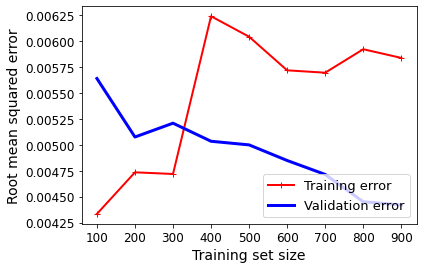

In [116]:
plot_learning_curves(nl_svm_all, dataset_prepared_stand, dataset_labels)

### Export model

In [117]:
ml_model = nl_svm_all
feats = features
pipeline = transformation_pipeline

#### For ABM

In [118]:
import csv
from numpy import savetxt 

def export_model_for_abm(ml_model, feats, pipeline, folder_path):
    scaler = StandardScaler() # Needs to be instantiated to be passed to the ABM if not fit in its initialization
    dataset_only_transf = pipeline.fit_transform(dataset) ##
    scaler.fit(dataset_only_transf)
    model_for_abm = Pipeline([
        ("scaling", scaler),
        ("regressor", ml_model)
    ])
    joblib.dump(model_for_abm, os.path.join(folder_path, 'model.pkl'))
    # Check
    print(model_for_abm.predict(dataset_only_transf[0, :].reshape(1, -1))[0])
    
    #Export features name
    with open(os.path.join(folder_path, 'features.csv'), "w+") as file:
        wr = csv.writer(file)
        wr.writerow(feats)
    
    savetxt(os.path.join(folder_path, 'dataset.csv'), dataset_only_transf, delimiter=',')
    savetxt(os.path.join(folder_path, 'labels.csv'), dataset_labels.values,  delimiter=',') ##

In [119]:
folder_path = './Models for ABM/all_adoption/regressor'

In [120]:
export_model_for_abm(ml_model, feats, pipeline, folder_path)

0.004834441284494704


#### For model analysis

In [121]:
joblib.dump(ml_model, './Models to analyse/all_adoption/regressor/nl_svm.pkl')

['./Models to analyse/all_adoption/regressor/nl_svm.pkl']